# Анализ пользовательского поведения и сезонности спроса в сервисе Яндекс Афиша

## Введение

### Цели и задачи проекта

**Цель проекта** - подготовить и исследовать данные о заказах билетов на сервисе Яндекс Афиша, чтобы выявить сезонные изменения пользовательского поведения, востребованность мероприятий и ключевых партнёров осенью 2024 года.

**Задачи:**
- Загрузить данные, проверить их корректность и провести предобработку (пропуски, дубликаты, типы данных, аномалии).
- Нормализовать категориальные и количественные данные, создать необходимые для анализа столбцы (revenue_rub, one_ticket_revenue_rub, month, season).
- Изучить распределение заказов по сегментам: тип мероприятия, тип устройства, возрастные категории; сравнить летний и осенний периоды.
- Проанализировать сезонную динамику активности пользователей осенью: заказы, DAU, средние показатели, недельная цикличность.
- Оценить популярность событий и вклад партнёров и регионов в общее число заказов и выручку.
- Проверить две статистические гипотезы о различиях в поведении пользователей мобильных и стационарных устройств.
- Сформировать общий вывод и рекомендации для бизнеса на основе выявленных закономерностей.

### Описание данных

В проекте будут использованы данные из датасетов `final_tickets_orders_df.csv`, `final_tickets_events_df.csv` и `final_tickets_tenge_df.csv`.
- `final_tickets_orders_df.csv` — информация о всех заказах билетов, совершённых с двух типов устройств (мобильных и стационарных).
- `final_tickets_events_df.csv` — информация о событиях и площадках проведения мероприятий.
- `final_tickets_tenge_df.csv` — информация о курсе тенге к рублю.

### Описание датасета `final_tickets_orders_df.csv`
- `order_id` — уникальный идентификатор заказа.
- `user_id` — уникальный идентификатор пользователя.
- `created_dt_msk` — дата создания заказа (московское время).
- `created_ts_msk` — дата и время создания заказа (московское время).
- `event_id` — идентификатор мероприятия из таблицы events.
- `cinema_circuit` — сеть кинотеатров. Если не применимо, то здесь будет значение 'нет'.
- `age_limit` — возрастное ограничение мероприятия.
- `currency_code` — валюта оплаты, например rub для российских рублей.
- `device_type_canonical` — тип устройства, с которого был оформлен заказ.
- `revenue` — выручка от заказа.
- `service_name` — название билетного оператора.
- `tickets_count` — количество купленных билетов.
- `total` — общая сумма заказа.

### Описание датасета `final_tickets_events_df.csv`
- `event_id` — уникальный идентификатор мероприятия.
- `event_name` — название мероприятия. Аналог поля event_name_code из исходной базы данных.
- `event_type_description` — описание типа мероприятия.
- `event_type_main` — основной тип мероприятия: театральная постановка, концерт и так далее.
- `organizers` — организаторы мероприятия.
- `region_name` — название региона.
- `city_name` — название города.
- `venue_id` — уникальный идентификатор площадки.
- `venue_name` — название площадки.
- `venue_address` — адрес площадки.

### Описание датасета `final_tickets_tenge_df.csv`
- `nominal` — номинал (100 тенге).
- `data` — дата.
- `curs` — курс тенге к рублю.
- `cdx` — обозначение валюты (kzt).

## Загрузка и знакомство с данными

In [1]:
# Импортируем необходимые библиотеки.
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu
from scipy.stats import ttest_ind

In [2]:
# Настраиваем pandas так, чтобы при выводе датафрейма отображались все столбцы, для лучшей читаемости.
pd.set_option("display.max_columns", None)  
pd.set_option("display.width", None)    

In [3]:
# Создаем константу для хранения частичного пути до датасета.
PATH = ...
# Загружаем датасеты из CSV-файлов.
final_tickets_orders_df = pd.read_csv(PATH + 'final_tickets_orders_df.csv')
final_tickets_events_df = pd.read_csv(PATH + 'final_tickets_events_df.csv')
final_tickets_tenge_df = pd.read_csv(PATH + 'final_tickets_tenge_df.csv')

In [4]:
# Выводим информацию о датафрейме final_tickets_orders_df.
final_tickets_orders_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290849 entries, 0 to 290848
Data columns (total 14 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   order_id               290849 non-null  int64  
 1   user_id                290849 non-null  object 
 2   created_dt_msk         290849 non-null  object 
 3   created_ts_msk         290849 non-null  object 
 4   event_id               290849 non-null  int64  
 5   cinema_circuit         290849 non-null  object 
 6   age_limit              290849 non-null  int64  
 7   currency_code          290849 non-null  object 
 8   device_type_canonical  290849 non-null  object 
 9   revenue                290849 non-null  float64
 10  service_name           290849 non-null  object 
 11  tickets_count          290849 non-null  int64  
 12  total                  290849 non-null  float64
 13  days_since_prev        268909 non-null  float64
dtypes: float64(3), int64(4), object(7)
m

In [5]:
# Выводим первые строки датафрейма final_tickets_orders_df.
final_tickets_orders_df.head()

,order_id,user_id,created_dt_msk,created_ts_msk,event_id,cinema_circuit,age_limit,currency_code,device_type_canonical,revenue,service_name,tickets_count,total,days_since_prev
0,4359165,0002849b70a3ce2,2024-08-20,2024-08-20 16:08:03,169230,нет,16,rub,mobile,1521.94,Край билетов,4,10870.99,NaN
1,7965605,0005ca5e93f2cf4,2024-07-23,2024-07-23 18:36:24,237325,нет,0,rub,mobile,289.45,Мой билет,2,2067.51,NaN
2,7292370,0005ca5e93f2cf4,2024-10-06,2024-10-06 13:56:02,578454,нет,0,rub,mobile,1258.57,За билетом!,4,13984.16,75.0
3,1139875,000898990054619,2024-07-13,2024-07-13 19:40:48,387271,нет,0,rub,mobile,8.49,Лови билет!,2,212.28,NaN
4,972400,000898990054619,2024-10-04,2024-10-04 22:33:15,509453,нет,18,rub,mobile,1390.41,Билеты без проблем,3,10695.43,83.0


In [6]:
# Выводим информацию о датафрейме final_tickets_events_df.
final_tickets_events_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22427 entries, 0 to 22426
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   event_id                22427 non-null  int64 
 1   event_name              22427 non-null  object
 2   event_type_description  22427 non-null  object
 3   event_type_main         22427 non-null  object
 4   organizers              22427 non-null  object
 5   region_name             22427 non-null  object
 6   city_name               22427 non-null  object
 7   city_id                 22427 non-null  int64 
 8   venue_id                22427 non-null  int64 
 9   venue_name              22427 non-null  object
 10  venue_address           22427 non-null  object
dtypes: int64(3), object(8)
memory usage: 1.9+ MB


In [7]:
# Выводим первые строки датафрейма final_tickets_events_df.
final_tickets_events_df.head()

,event_id,event_name,event_type_description,event_type_main,organizers,region_name,city_name,city_id,venue_id,venue_name,venue_address
0,4436,e4f26fba-da77-4c61-928a-6c3e434d793f,спектакль,театр,№4893,Североярская область,Озёрск,2,1600,"Кладбище искусств ""Проблема"" и партнеры","наб. Загородная, д. 785"
1,5785,5cc08a60-fdea-4186-9bb2-bffc3603fb77,спектакль,театр,№1931,Светополянский округ,Глиноград,54,2196,"Лекции по искусству ""Свет"" Групп","ул. Ягодная, д. 942"
2,8817,8e379a89-3a10-4811-ba06-ec22ebebe989,спектакль,театр,№4896,Североярская область,Озёрск,2,4043,"Кинокомитет ""Золотая"" Инк","ш. Коммуны, д. 92 стр. 6"
3,8849,682e3129-6a32-4952-9d8a-ef7f60d4c247,спектакль,театр,№4960,Каменевский регион,Глиногорск,213,1987,"Выставка ремесел ""Свет"" Лтд","пер. Набережный, д. 35"
4,8850,d6e99176-c77f-4af0-9222-07c571f6c624,спектакль,театр,№4770,Лесодальний край,Родниковец,55,4230,"Фестивальный проект ""Листья"" Групп","пер. Проезжий, д. 9"


In [8]:
# Выводим информацию о датафрейме final_tickets_tenge_df.
final_tickets_tenge_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 357 entries, 0 to 356
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   data     357 non-null    object 
 1   nominal  357 non-null    int64  
 2   curs     357 non-null    float64
 3   cdx      357 non-null    object 
dtypes: float64(1), int64(1), object(2)
memory usage: 11.3+ KB


In [9]:
# Выводим первые строки датафрейма final_tickets_tenge_df.
final_tickets_tenge_df.head()

,data,nominal,curs,cdx
0,2024-01-10,100,19.9391,kzt
1,2024-01-11,100,19.7255,kzt
2,2024-01-12,100,19.5839,kzt
3,2024-01-13,100,19.4501,kzt
4,2024-01-14,100,19.4501,kzt


***final_tickets_orders_df***
- Столбцы `order_id`, `event_id`, `age_limit`, `tickets_count`, `revenue`, `total` и `days_since_prev` необходимо привести к менее ресурсоемким типам.
- Столбцы `created_dt_msk` и `created_ts_msk` необходимо привести к типу `datetime` поскольку они хранят информацию о дате и времени.
- Пропуски обнаружены только в столбце `days_since_prev`, столбец хранит данные о предыдущей покупке, поэтому пропуски в столбце не являются ошибками.

***final_tickets_events_df***
- Столбцы `event_id`, `city_id` и `venue_id` необходимо привести к менее ресурсоемким типам.

***final_tickets_tenge_df***
- Необходимо заменить названия столбцов `data`, `curs` и `cdx` на `date`, `exchange_rate` и `currency_code` соответственно.
- Столбец `data` (`date`) необходимо привести к `datetime`, поскольку в нем хранятся даты.
- Столбцы `nominal` и `curs` (`exchange_rate`) нужно привести к менее ресурсоемким типам.

- При исследовании данных было выяснено что в основном все типы данных столбцов соответствуют хранимым значениям, за исключением столбцов хранящих дату и время, а также столбцов в которых необходимо понизить разрядность данных, поскольку их типы слишком ресурсоемки.
- Наименования столбцов датафреймов `final_tickets_orders_df` и `final_tickets_events_df` соответствуют данным, наименования столбцов датафрейма `final_tickets_tenge_df` необходимо исправить на более подходящие.
- Пропуски обнаружены только в датафрейме `final_tickets_orders_df` в столбце `days_since_prev`, однако они не являются ошибочными, а лишь говорят о том, что у пользователя ранее не было покупок.

## Предобработка данных и подготовка их к исследованию

- ***Объединяем данные в один датафрейм и проведим общую предобработку.***

In [10]:
# Объединяем датафреймы final_tickets_orders_df и final_tickets_events_df.
orders_and_events_df = final_tickets_orders_df.merge(final_tickets_events_df, how='inner', on='event_id')

In [11]:
# Объединяем новый датафрейм orders_and_events_df с final_tickets_events_df, в котором хранится информация о курсе валюты.
orders_and_events_df = orders_and_events_df.merge(final_tickets_tenge_df, how='left', left_on='created_dt_msk', right_on='data')

In [12]:
# Определяем изначальный размер датфрейма.
initial_shape = orders_and_events_df.shape[0]

- ***Преобразуем данные.***

In [13]:
# Преобразуем столбцы с датой и временем в datetime при помощи метода apply().
to_dt_cols = ['created_dt_msk', 'created_ts_msk', 'data']
orders_and_events_df[to_dt_cols] = orders_and_events_df[to_dt_cols].apply(pd.to_datetime, errors='coerce')

In [14]:
# Создаем списки с наименованиями столбцов которые необходимо преобразовать.
to_int_downcast = ['order_id', 'event_id', 'age_limit', 'tickets_count', 'city_id', 'venue_id']
to_float_downcast = ['revenue', 'total']

# Понижаем разрядность данных.
orders_and_events_df[to_int_downcast] = orders_and_events_df[to_int_downcast].apply(pd.to_numeric, downcast='integer')
orders_and_events_df[to_float_downcast] = orders_and_events_df[to_float_downcast].apply(pd.to_numeric, downcast='float')

# Приводим days_since_prev к типу nullable integer поскольку в столбце хранятся целочисленные значения и значения NaN.
# Максимальное значение в столбце - 148, поэтому выбран тип Int16 (Int8 не подойдет по диапазону).
orders_and_events_df['days_since_prev'] = orders_and_events_df['days_since_prev'].astype('Int16')

In [15]:
# Переименовываем наименование столбца curs в exchange_rate.
orders_and_events_df = orders_and_events_df.rename(columns={'curs': 'exchange_rate'})

In [16]:
# Проверяем совпадают ли значения в столбцах created_dt_msk и data.
if orders_and_events_df['created_dt_msk'].equals(orders_and_events_df['data']):
    print('Значения в столбцах created_dt_msk и data полностью совпадают.')
else:
    print('Значения в столбцах created_dt_msk и data не совпадают.')

# Выводим уникальные значения столбцов nominal и cdx.
print(f"Уникальные значения в столбце nominal: {orders_and_events_df['nominal'].unique()}")
print(f"Уникальные значения в столбце cdx: {orders_and_events_df['cdx'].unique()}")

Значения в столбцах created_dt_msk и data полностью совпадают.
Уникальные значения в столбце nominal: [100]
Уникальные значения в столбце cdx: ['kzt']


- Удаляем столбцы `data`, `nominal` и `cdx` из датафрейма. Столбец `data` дублирует информацию столбца `created_dt_msk`, а столбцы `nominal` и `cdx` хранят по одному уникальному значению (`100`/`kzt`) и не представляют ценности для исследования.

In [17]:
# Удаляем столбцы.
cols_to_drop = ['data', 'nominal', 'cdx']
orders_and_events_df = orders_and_events_df.drop(columns=cols_to_drop)

- ***Изучаем значения в ключевых столбцах.***

In [18]:
# Выводим категориальные данные.
categories = ['cinema_circuit', 'currency_code', 'device_type_canonical', 'event_type_description', 'event_type_main']
 
for col in categories:
    print(f'\n=== {col} ===')
    display(pd.DataFrame({
        "unique_values": orders_and_events_df[col].unique(),
        "count": orders_and_events_df[col].value_counts().values}))


=== cinema_circuit ===


,unique_values,count
0,нет,289213
1,Другое,1261
2,Киномакс,122
3,КиноСити,7
4,Москино,7
5,ЦентрФильм,1



=== currency_code ===


,unique_values,count
0,rub,285542
1,kzt,5069



=== device_type_canonical ===


,unique_values,count
0,mobile,232490
1,desktop,58121



=== event_type_description ===


,unique_values,count
0,спектакль,112049
1,событие,58605
2,цирковое шоу,50592
3,выставка,13626
4,шоу,12837
5,концерт,9919
6,спорт,9074
7,мюзикл,5998
8,фестиваль,5876
9,ёлка,5327



=== event_type_main ===


,unique_values,count
0,театр,115276
1,выставки,67321
2,другое,65867
3,стендап,21911
4,концерты,13393
5,спорт,4854
6,ёлки,1989


In [19]:
# Приводим значения столбца cinema_circuit к нижнему регистру для соотвествия общему стилю.
orders_and_events_df['cinema_circuit'] = orders_and_events_df['cinema_circuit'].str.strip().str.lower()

- Данные столбца `cinema_circuit` были приведены к нижнему регистру для соответствия общему стилю. Другие категориальные данные представленные в датафрейме корректны и не требуют нормализации.

- ***Изучаем значения поля revenue.***

In [20]:
# Выводим сводную статистику столбца revenue (RUB).
orders_and_events_df.loc[orders_and_events_df['currency_code'] == 'rub', 'revenue'].describe()

count    285542.000000
mean        548.013929
std         871.750181
min         -90.760000
25%         114.170000
50%         346.630000
75%         793.320000
max       81174.540000
Name: revenue, dtype: float64

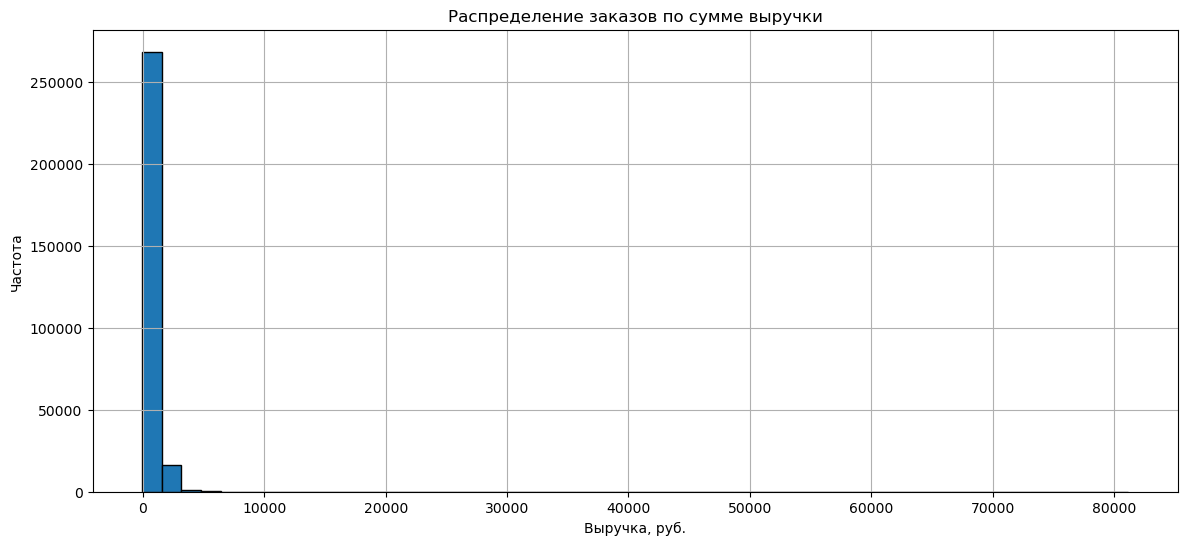

In [21]:
# Строим гистограмму распределения выручки для заказов с RUB.
orders_and_events_df.loc[orders_and_events_df['currency_code'] == 'rub', 'revenue'].plot(kind='hist', 
                                                                                         figsize=(14, 6), 
                                                                                         bins=50, 
                                                                                         grid=True, 
                                                                                         edgecolor='k')
plt.title('Распределение заказов по сумме выручки')
plt.ylabel('Частота')
plt.xlabel('Выручка, руб.')
plt.show()

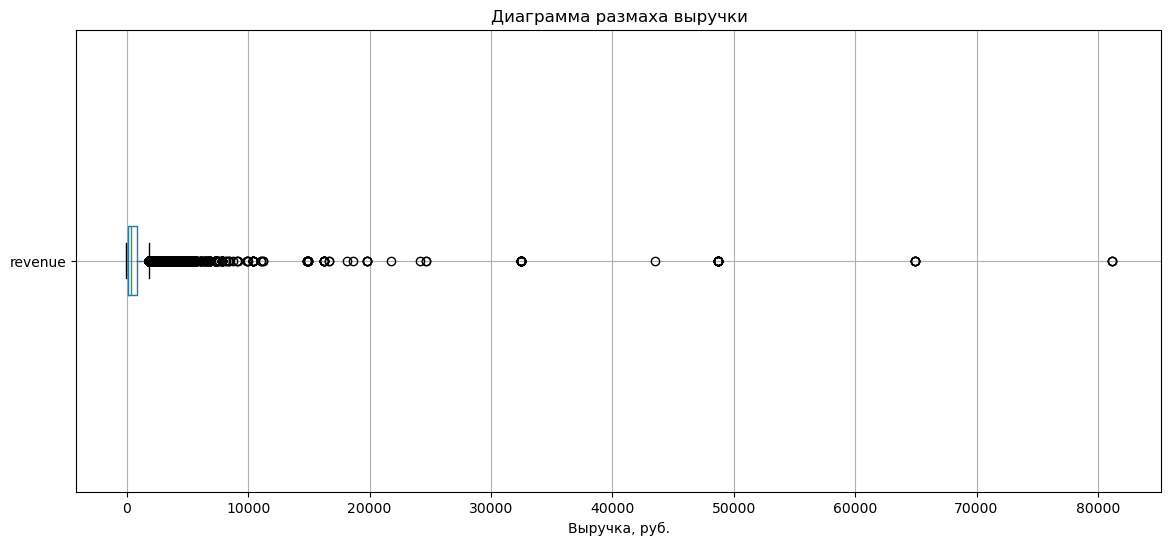

In [22]:
# Строим диаграмму размаха для заказов с RUB.
plt.figure(figsize=(14, 6))
orders_and_events_df.loc[orders_and_events_df['currency_code'] == 'rub'].boxplot(column='revenue', vert=False)
plt.title('Диаграмма размаха выручки')
plt.ylabel('')
plt.xlabel('Выручка, руб.')
plt.show()

- На графиках наблюдается сильная правосторонняя ассиметрия, сводная статистика столбца также указывает на это, медианное значение существенно ниже среднего (медиана: 346.6, среднее: 548).
- Высокое стандартное отклонение (871.8), наличие отрицательных и экстремально высоких значений (максимум: 81174.5) указывают на сильную вариативность данных и влияние выбросов, которые тянут среднее вверх.
- Для дальнейшего анализа необходимо исключить выбросы, то есть отрицательные значения, и значения превышающие 99-й процентиль.

In [23]:
# Выводим сводную статистику по столбцу revenue с валютой KZT.
orders_and_events_df.loc[orders_and_events_df['currency_code'] == 'kzt', 'revenue'].describe()

count     5069.000000
mean      4995.206767
std       4916.752776
min          0.000000
25%        518.100000
50%       3698.830000
75%       7397.660000
max      26425.860000
Name: revenue, dtype: float64

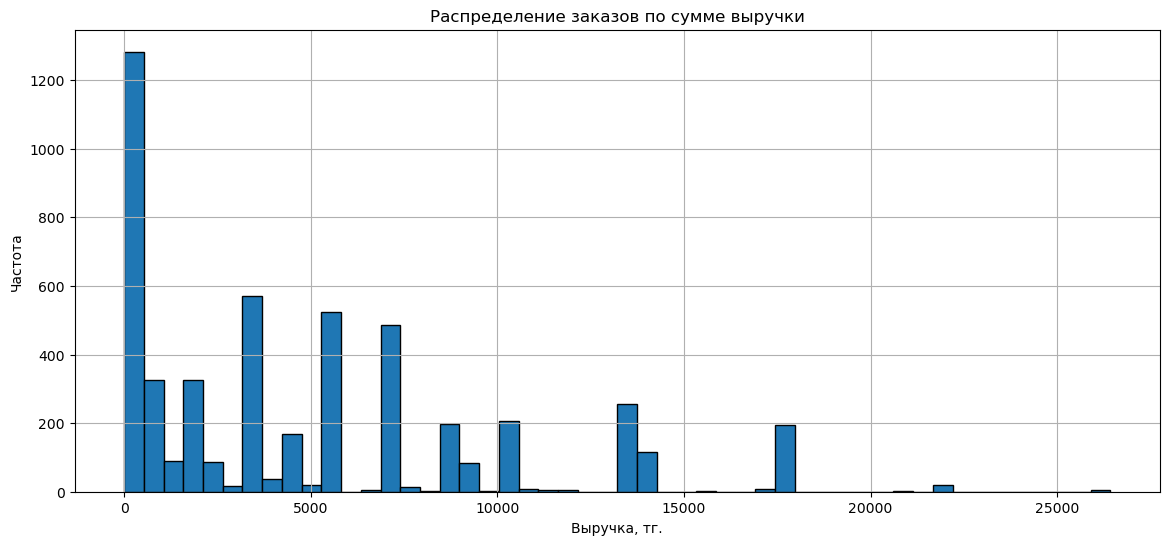

In [24]:
# Строим гистограмму распределения выручки для заказов с KZT.
orders_and_events_df.loc[orders_and_events_df['currency_code'] == 'kzt', 'revenue'].plot(kind='hist', 
                                                                                         figsize=(14, 6), 
                                                                                         bins=50, 
                                                                                         grid=True, 
                                                                                         edgecolor='k')
plt.title('Распределение заказов по сумме выручки')
plt.ylabel('Частота')
plt.xlabel('Выручка, тг.')
plt.show()

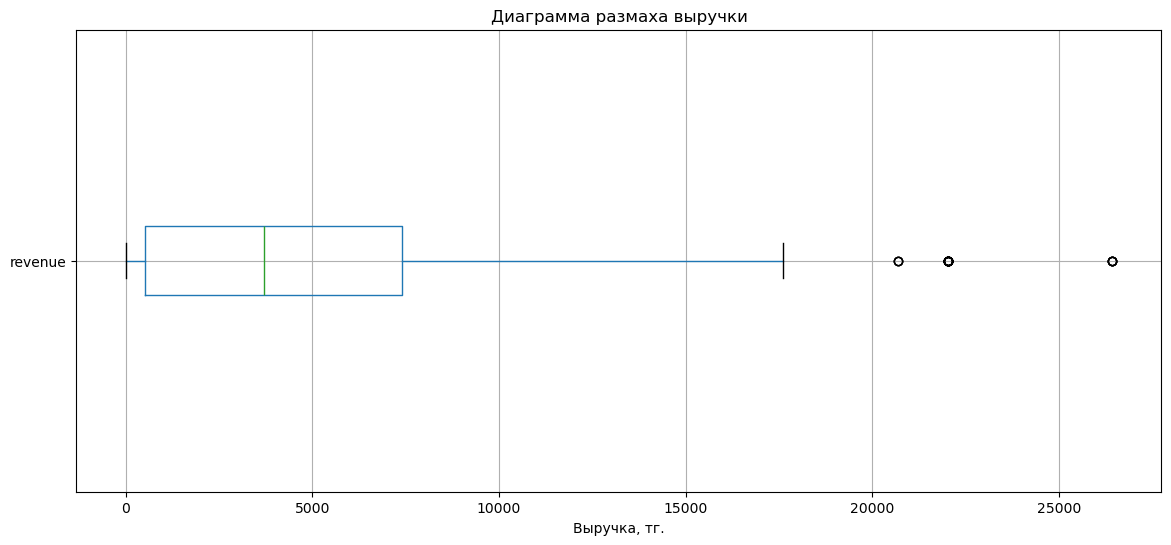

In [25]:
# Строим диаграмму размаха для заказов с KZT.
plt.figure(figsize=(14, 6))
orders_and_events_df.loc[orders_and_events_df['currency_code'] == 'kzt'].boxplot(column='revenue', vert=False)
plt.title('Диаграмма размаха выручки')
plt.ylabel('')
plt.xlabel('Выручка, тг.')
plt.show()

- На графиках наблюдается правосторонняя ассиметрия, она чуть менее выраженная в сравнении с предыдущим графиком (RUB), разница между медианным (3698.8) и средним (4995.2) значениями это подтверждает.
- В данных присутствуют экстремально высокие значения (максимум: 26425.9), стандартное отклонение также высокое (4916.8), присутствует сильная вариативность. Отрицательных значений нет.
- Для дальнейшего анализа необходимо исключить экстремально высокие значения превышающие 99-й процентиль. 

- Фильтрация выбросов будет произведена до конвертации валют, поскольку 99-й процентиль рассчитывается отдельно по каждой валюте. Это позволяет корректно отсечь экстремальные значения в рамках каждой ценовой шкалы. Если сначала выполнить конвертацию, процентиль будет рассчитан по объединённым данным и будет смещён в сторону валюты с более высокими выручками, что приведёт к некорректному отсечению значений.

- ***Исключаем экстремальные значения из поля revenue.***

In [26]:
# Исключаем нули и значения превышающие 99-й процентиль.

# Определяем 99-й процентиль для каждой валюты.
q99_kzt = orders_and_events_df.loc[orders_and_events_df['currency_code'] == 'kzt', 'revenue'].quantile(0.99)
q99_rub = orders_and_events_df.loc[orders_and_events_df['currency_code'] == 'rub', 'revenue'].quantile(0.99)

# Фильтрация KZT.
mask_kzt = (orders_and_events_df['currency_code'] == 'kzt') & (orders_and_events_df['revenue'] <= q99_kzt)

# Фильтрация RUB.
mask_rub = (orders_and_events_df['currency_code'] == 'rub') & \
           (orders_and_events_df['revenue'] <= q99_rub) & \
           (orders_and_events_df['revenue'] > 0)

# Объединяем два условия.
orders_and_events_df = orders_and_events_df[mask_kzt | mask_rub]

In [27]:
# Расситываем количество удаленных записей на данном этапе, в абсолютном и относительном виде.
deleted_rows = initial_shape - orders_and_events_df.shape[0]
deleted_rows_share = (deleted_rows / initial_shape) * 100
print(f'Из датафрейма было удалено {deleted_rows} записей ({deleted_rows_share}% данных).')

Из датафрейма было удалено 8730 записей (3.004015677314348% данных).


- ***Добавляем новые столбцы.***

In [28]:
# Создаем константу для хранения номинала (100 тг.) который нужен для последующий расчетов. 
RATE_UNIT_KZT = 100

# Создаем столбец revenue_rub в котором будут храниться сконвертированные выручки для столбцов с тенге, и выручкой без
# изменений для столбцов с рублем.
orders_and_events_df['revenue_rub'] = 0.0

# При помощи метода loc добавляем значения в столбец производя необходимые расчеты.
orders_and_events_df.loc[orders_and_events_df['currency_code'] == 'kzt', 'revenue_rub'] =  orders_and_events_df['revenue'] / (RATE_UNIT_KZT / orders_and_events_df['exchange_rate'])
orders_and_events_df.loc[orders_and_events_df['currency_code'] == 'rub', 'revenue_rub'] = orders_and_events_df['revenue']

In [29]:
# Создаем столбец с информацией о выручке с продажи одного билета на мероприятие.
orders_and_events_df['one_ticket_revenue_rub'] = orders_and_events_df['revenue_rub'] / orders_and_events_df['tickets_count']

In [30]:
# Создаем столбец с информацией о месяце оформления заказа.
orders_and_events_df['month'] = orders_and_events_df['created_dt_msk'].dt.month

In [31]:
# Создаем функцию для определения сезона по номеру месяца.
def set_season(month):
    if month in [12, 1, 2]:
        return 'зима'
    elif month in [3, 4, 5]:
        return 'весна'
    elif month in [6, 7, 8]:
        return 'лето'
    else:
        return 'осень'
    
# Создаём столбец season, применяя функцию set_season к каждому значению столбца month.
orders_and_events_df['season'] = orders_and_events_df['month'].apply(set_season)

- ***Изучаем значения поля tickets_count.***

In [32]:
# Выводим сводную статистику столбца tickets_count.
orders_and_events_df['tickets_count'].describe()

count    281881.000000
mean          2.743821
std           1.156577
min           1.000000
25%           2.000000
50%           3.000000
75%           3.000000
max          47.000000
Name: tickets_count, dtype: float64

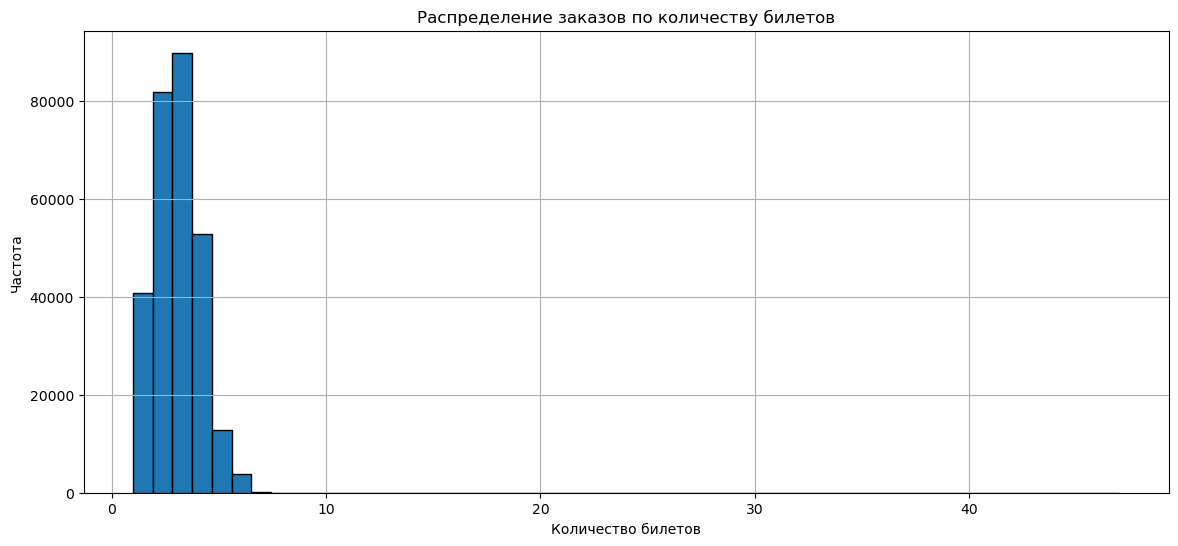

In [33]:
# Строим гистограмму распределения заказов по количеству билетов.
orders_and_events_df['tickets_count'].plot(kind='hist', figsize=(14, 6), bins=50, grid=True, edgecolor='k')
plt.title('Распределение заказов по количеству билетов')
plt.ylabel('Частота')
plt.xlabel('Количество билетов')
plt.show()

In [34]:
# Выводим таблицу со средним чеком за один билет и количеством заказов для каждого количества билетов.
orders_and_events_df.groupby('tickets_count').agg(one_ticket_mean=('one_ticket_revenue_rub', 'mean'), order_count=('order_id', 'count'))

,one_ticket_mean,order_count
tickets_count,,
1,188.910611,40726
2,201.539725,81811
3,197.711512,89796
4,198.293986,52775
5,157.644826,12719
6,141.502571,3880
7,102.834975,58
8,108.714861,18
9,101.803246,38


In [35]:
# Расчитываем процентное соотношение записей с количеством билетов больше 6.
more_than_6 = orders_and_events_df[orders_and_events_df['tickets_count'] > 6].shape[0]
less_than_7 = orders_and_events_df[orders_and_events_df['tickets_count'] <= 6].shape[0]

print(f"Записей со значением количества билетов меньше или равно 6: {less_than_7 / orders_and_events_df.shape[0] * 100}%")
print(f"Записей со значением количества билетов больше 6: {more_than_6 / orders_and_events_df.shape[0] * 100}%")

Записей со значением количества билетов меньше или равно 6: 99.93827182392569%
Записей со значением количества билетов больше 6: 0.06172817607430085%


In [36]:
# Выводим первые 5 строк записей с количеством билетов больше 6.
orders_and_events_df[orders_and_events_df['tickets_count'] > 6].head()

,order_id,user_id,created_dt_msk,created_ts_msk,event_id,cinema_circuit,age_limit,currency_code,device_type_canonical,revenue,service_name,tickets_count,total,days_since_prev,event_name,event_type_description,event_type_main,organizers,region_name,city_name,city_id,venue_id,venue_name,venue_address,exchange_rate,revenue_rub,one_ticket_revenue_rub,month,season
1140,4486939,019fa401ddb00aa,2024-09-13,2024-09-13 12:19:52,562954,нет,18,rub,mobile,1260.62,Билеты без проблем,10,25212.40,0,b6a34397-5581-4d0d-8ee7-62e9852ac06c,концерт,концерты,№4520,Североярская область,Озёрск,2,924,"Арт-фестиваль ""Ключ"" Инкорпорэйтед","бул. 9 Января, д. 870 к. 66",19.0758,1260.62,126.062000,9,осень
2846,1692296,0263f0dddb290b6,2024-10-21,2024-10-21 22:40:19,586844,нет,0,rub,mobile,1231.70,Мой билет,9,41056.56,<NA>,0aeb1f89-dfc3-4171-bfaa-e1960df7f37a,событие,другое,№4434,Североярская область,Озёрск,2,924,"Арт-фестиваль ""Ключ"" Инкорпорэйтед","бул. 9 Января, д. 870 к. 66",19.7884,1231.70,136.855556,10,осень
4999,4057710,02ea4583333f064,2024-09-24,2024-09-24 17:13:23,446456,нет,18,rub,mobile,1225.61,Билеты без проблем,7,40853.51,0,9d3e6cf4-0e79-47a3-a632-3f058d32ddfc,событие,другое,№4520,Североярская область,Озёрск,2,924,"Арт-фестиваль ""Ключ"" Инкорпорэйтед","бул. 9 Января, д. 870 к. 66",19.3967,1225.61,175.087143,9,осень
10465,6301150,05ba93f1b1e1fdd,2024-08-17,2024-08-17 14:25:06,555072,нет,18,rub,mobile,582.78,Билеты без проблем,7,19425.86,1,ce448a71-45ad-4254-8292-062bdea65755,событие,другое,№4520,Североярская область,Озёрск,2,924,"Арт-фестиваль ""Ключ"" Инкорпорэйтед","бул. 9 Января, д. 870 к. 66",18.5775,582.78,83.254286,8,лето
12389,3769624,07fac55c42e3414,2024-06-13,2024-06-13 22:54:44,529629,нет,18,rub,mobile,877.70,Билеты без проблем,7,21942.48,1,30e84abc-b350-4a7d-a54b-5943680b54b0,событие,другое,№4520,Североярская область,Озёрск,2,924,"Арт-фестиваль ""Ключ"" Инкорпорэйтед","бул. 9 Января, д. 870 к. 66",19.8655,877.70,125.385714,6,лето


In [37]:
# Находим среднее по выборке без фильтрации.
orders_and_events_df['one_ticket_revenue_rub'].mean()

np.float64(195.01842822796692)

In [38]:
# Находим среднее отфильтрованной выборки.
orders_and_events_df.loc[orders_and_events_df['tickets_count'] <= 6, 'one_ticket_revenue_rub'].mean()

np.float64(195.07687986626507)

- Гистограмма распределения показала что большая часть заказов сосредоточена на отметках от 1 до 6 билетов.
- Заказы с большим количеством билетов (более 6) встречаются крайне редко - примерно 0.06% выборки, и представляют собой групповые покупки, часто по заниженной стоимости (вероятно мероприятия с символической стоимотью или бесплатные).
- Такие записи малочисленны и они имеют незначительное влияние на среднее (выборка без фильтрации: 195.02, с фильтрацией: 195.08). Поэтому удалять такие значения не требуется, дальнейший анализ будет проводиться с полной выборкой.

- ***Проверяем на дубликаты.***

In [39]:
# Проверяем датафрейм на наличие явных дубликатов.
orders_and_events_df.duplicated().sum()

np.int64(0)

In [40]:
# Определяем количество неявных дубликатов.

# Создаем список со всеми полями кроме order_id для поиска неявных дубликатов.
except_order_id = ['user_id', 'created_dt_msk', 'created_ts_msk', 'event_id',
       'cinema_circuit', 'age_limit', 'currency_code', 'device_type_canonical',
       'revenue', 'service_name', 'tickets_count', 'total', 'days_since_prev',
       'event_name', 'event_type_description', 'event_type_main', 'organizers',
       'region_name', 'city_name', 'city_id', 'venue_id', 'venue_name',
       'venue_address', 'exchange_rate', 'revenue_rub',
       'one_ticket_revenue_rub', 'month', 'season']

# Выводим количество неявных дубликатов.
print('Количество дубликатов без учета order_id:', orders_and_events_df.duplicated(subset=except_order_id).sum())

Количество дубликатов без учета order_id: 29


In [41]:
# Выводим предполагаемые неявные дубликаты.
orders_and_events_df[orders_and_events_df.duplicated(subset=except_order_id, keep=False)].head()

,order_id,user_id,created_dt_msk,created_ts_msk,event_id,cinema_circuit,age_limit,currency_code,device_type_canonical,revenue,service_name,tickets_count,total,days_since_prev,event_name,event_type_description,event_type_main,organizers,region_name,city_name,city_id,venue_id,venue_name,venue_address,exchange_rate,revenue_rub,one_ticket_revenue_rub,month,season
11759,1123983,06eb7897f65b433,2024-08-13,2024-08-13 16:31:07,183706,нет,18,rub,mobile,69.82,Билеты в руки,1,997.48,0,69796237-909b-42a7-bfb5-c1b8574c4c76,спектакль,театр,№1482,Светополянский округ,Глиноград,54,4443,"Центр культурного наследия ""Объединение"" и пар...","бул. Карбышева, д. 50",18.8553,69.82,69.820,8,лето
11760,1123867,06eb7897f65b433,2024-08-13,2024-08-13 16:31:07,183706,нет,18,rub,mobile,69.82,Билеты в руки,1,997.48,0,69796237-909b-42a7-bfb5-c1b8574c4c76,спектакль,театр,№1482,Светополянский округ,Глиноград,54,4443,"Центр культурного наследия ""Объединение"" и пар...","бул. Карбышева, д. 50",18.8553,69.82,69.820,8,лето
57173,160922,2564e3703075008,2024-10-30,2024-10-30 10:04:15,589005,нет,6,rub,mobile,11.23,Лови билет!,2,280.81,0,bee8d0cc-282b-492e-9ed8-ec0990f43ffd,выставка,другое,№1810,Яблоневская область,Горяново,11036,1656,"Модная академия ""Пункт"" Лимитед","бул. Гагарина, д. 39",19.9516,11.23,5.615,10,осень
57176,160893,2564e3703075008,2024-10-30,2024-10-30 10:04:15,589005,нет,6,rub,mobile,11.23,Лови билет!,2,280.81,0,bee8d0cc-282b-492e-9ed8-ec0990f43ffd,выставка,другое,№1810,Яблоневская область,Горяново,11036,1656,"Модная академия ""Пункт"" Лимитед","бул. Гагарина, д. 39",19.9516,11.23,5.615,10,осень
83932,3363711,3ee7dc2e115847f,2024-06-25,2024-06-25 07:32:08,277504,нет,6,rub,mobile,59.19,Билеты в руки,3,739.85,0,dcb6fe75-8502-480d-b8a2-6bee187cb7ee,событие,выставки,№5015,Нежинская область,Каменёвка,76,3094,"Сообщество художников ""Палитра"" и партнеры","пр. Театральный, д. 161 стр. 2",18.8012,59.19,19.730,6,лето


- Строки представляют собой полные дубли, без учета поля `order_id`. Для проведения дальнейшего анализа записи будут удалены.

In [42]:
# Удаляем неявные дубликаты.
orders_and_events_df.drop_duplicates(subset=except_order_id, inplace=True)

- Из датафрейма были удалены 29 неявных дубликатов, они были отобраны по всем полям кроме `order_id`.
- Подобные записи могли появиться вследствие технической ошибки.

In [43]:
# Расситываем количество удаленных записей в абсолютном и относительном виде.
deleted_rows = initial_shape - orders_and_events_df.shape[0]
deleted_rows_share = (deleted_rows / initial_shape) * 100
print(f'Из исходного датафрейма было удалено {deleted_rows} записей, что составляет {deleted_rows_share}% данных.')

Из исходного датафрейма было удалено 8759 записей, что составляет 3.013994652645633% данных.


- Столбцы хранящие дату и время (`created_dt_msk`, `created_ts_msk`) были преобразованы из `object` в `datetime`.
- Столбцы хранящие числа (`int`/`float`) были приведены к менее ресурсоемким типам путем понижения разрядности.
- Столбец `days_since_prev` был преобразован из `float64` в `Int16` (nullable integer), поскольку хранит целочисленные значения и NaN.
- Столбец `curs` был переименован в `exchange_rate`.
- Удалены столбцы `data`, `nominal` и `cdx`, поскольку столбец `data` дублирует информацию столбца `created_dt_msk`, а столбцы `nominal` и `cdx` хранят по одному уникальному значению (`100`/`kzt`) и не представляют ценности для исследования.

- Изучены категориальные данные. Изменению подвергся только столбец `cinema_circuit`, его значения были приведены в нижний регистр для соответствия общему стилю, другие данные корректны и не требуют нормализации.
- Изучены количественные данные (`revenue`, `tickets_count`). 
    - Анализ столбца `tickets_count` проводился с учетом наличия в данных двух валют. В обоих сегментах были обнаружены экстремально высокие значения, а также нулевые значения в данных с валютой RUB. Нулевые значения были удалены, а экстремально высокие значения отсечены по 99-му процентилю. 
    - Изучены значения столбца `tickets_count`, в столбце присутствуют нетипичные значения количества билетов на один заказ (более 6), однако их нельзя однозначно назвать выбросами, часто в таких заказах занижена стоимость за один билет, либо билет бесплатный. Можно предположить что такие заказы представляют собой групповые покупки которые в меньшей степени отражают поведение пользователей, однако таких данных незначительно мало чтобы негативно повлиять на показатели (около 0.06%), поэтому такие записи не были удалены.

- В датафрейм были добавлены новые столбцы:
    - `revenue_rub` - выручка с заказа в единой валюте (RUB);
    - `one_ticket_revenue_rub` - выручка с продажи одного билета на мероприятие;
    - `month` - номер месяца в котором был оформлен заказ;
    - `season` - сезон.
- Из исходного датафрейма было удалено 8759 записей, что составляет примерно 3.01% данных (записи с выбросами в поле `revenue`, неявные дубликаты).

## Исследовательский анализ данных

### Анализ распределения заказов по сегментам и их сезонные изменения

In [44]:
# Считаем количество заказов для каждого месяца и выводим результат.
orders_by_month = orders_and_events_df.groupby('month')['order_id'].agg('count')

pd.DataFrame(orders_by_month)

,order_id
month,
6,32899
7,37884
8,43174
9,68892
10,99003


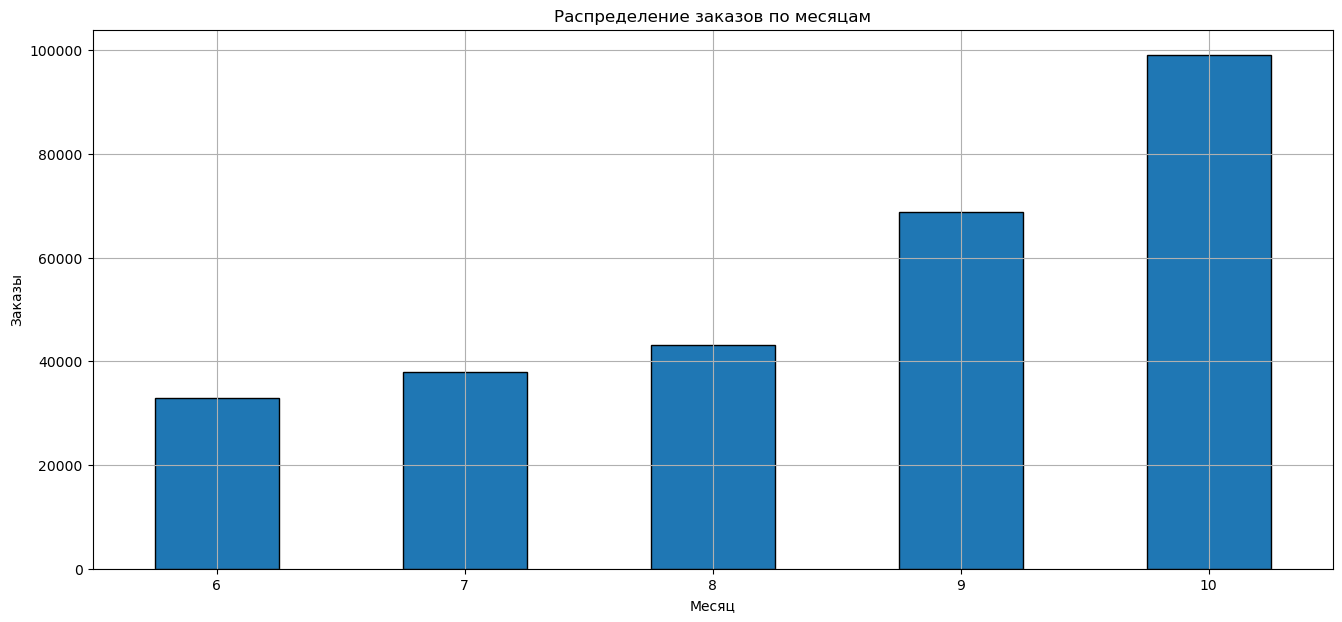

In [45]:
# Строим столбчатый график отражающий распределение заказов по месяцам.
orders_by_month.plot(kind='bar', 
                     figsize=(16, 7),
                     grid=True,
                     edgecolor='k',
                     rot=0)

plt.title('Распределение заказов по месяцам')
plt.ylabel('Заказы')
plt.xlabel('Месяц')
plt.show()

- Анализ распределения заказов по месяцам показывает выраженную восходящую динамику. Начиная с июня (32,9 тыс. заказов), объём заказов стабильно растёт каждый месяц и достигает максимума в октябре - 99 тыс. заказов.
- С июня по октябрь количество заказов увеличилось на 200.93%, что подтверждает наличие выраженной сезонности и увеличение пользовательской активности в осенний период.

In [46]:
# Создаем два датафрейма для каждого сезона.
summer_orders = orders_and_events_df[orders_and_events_df['season'] == 'лето']
autumn_orders = orders_and_events_df[orders_and_events_df['season'] == 'осень']

# Рассчитываем доли заказов по типу мероприятий.
events_summer = summer_orders.groupby('event_type_main').size() / len(summer_orders)
events_autumn = autumn_orders.groupby('event_type_main').size() / len(autumn_orders)

# Создаем и выводим датафрейм с долями каждого типа мероприятия по месяцам.
df_events = pd.DataFrame({'Лето': events_summer,'Осень': events_autumn})

df_events

,Лето,Осень
event_type_main,,
выставки,0.021122,0.014307
другое,0.249963,0.194568
концерты,0.438639,0.373597
спорт,0.024237,0.111844
стендап,0.055688,0.041234
театр,0.207956,0.254379
ёлки,0.002396,0.010072


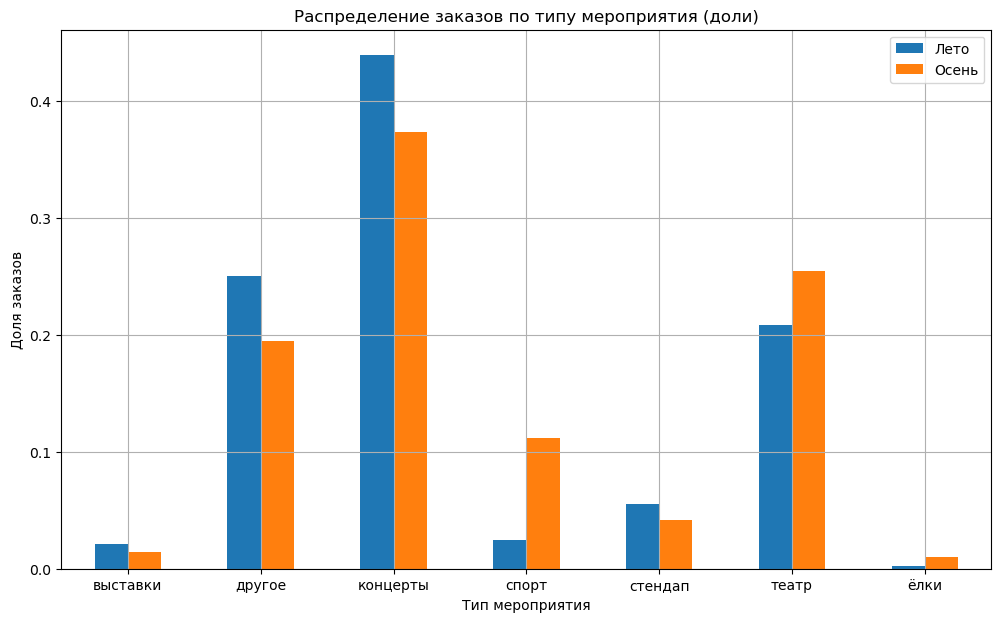

In [47]:
# Строим график отражающий распределение заказов по типам мероприятий для каждого месяца (в долях).
df_events.plot(kind='bar', figsize=(12, 7), rot=0, grid=True)
plt.title('Распределение заказов по типу мероприятия (доли)')
plt.ylabel('Доля заказов')
plt.xlabel('Тип мероприятия')
plt.show()

- `Концерты` остаются самым популярными типом мероприятий, однако осенью заметен спад (лето: 43.9%, осень: 37.4%). Можно предположить, что летом концертов больше из-за возможности проводить их на открытом воздухе.
- Рост популярности показали события с типом `"ёлки"` что вполне естественно учитывая приближение новогодних праздников (лето: 0,2%, осень: 1%).
- `Театр`: мероприятия набирают популярность осенью (лето: 20.8%, осень: 25.4%), вероятно связано с увеличением количества премьер.
- Осенью заметно набирают популярность `спортивные события` (лето: 2.4%, осень: 11.2%). Для большинства массовых видов спорта осень является началом сезона, можно предположить, что это и послужило причиной скачка.
- `Выставки` немного теряют в популярности в осеннее время (лето: 2.1%, осень: 1.4%), можно предположить, что популярность могла уменьшиться из-за невозможности проведения выставок на открытом воздухе, также, это может быть связано со смещением интереса в пользу других событий.
- `Стендап`: немного снижается популярность осенью (лето: 5.6%, осень: 4.1%), также, вероятно снижение интереса ввиду наличия альтернативных мероприятий.
- Категория `"другое"`: осенью наблюдается спад (лето: 24.9%, осень: 19.5%), поскольку в эту категорию могут входить разные типы, можно лишь предположить, что причиной является сезонность мероприятий.

In [48]:
# Рассчитываем доли заказов по типу устройств.
devices_summer = summer_orders.groupby('device_type_canonical').size() / len(summer_orders)
devices_autumn = autumn_orders.groupby('device_type_canonical').size() / len(autumn_orders)

# Создаем и выводим датафрейм с долями каждого типа устройства по сезонам.
df_devices = pd.DataFrame({'Лето': devices_summer,'Осень': devices_autumn})
df_devices

,Лето,Осень
device_type_canonical,,
desktop,0.191133,0.203931
mobile,0.808867,0.796069


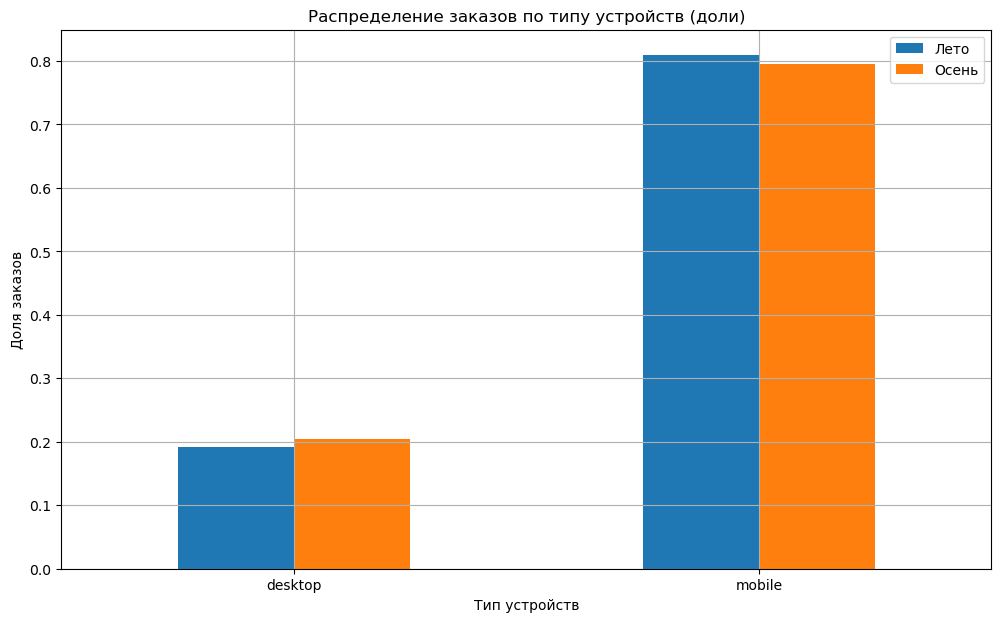

In [49]:
# Строим график отражающий распределение заказов по типам устройств для каждого месяца (в долях).
df_devices.plot(kind='bar', figsize=(12, 7), rot=0, grid=True)
plt.title('Распределение заказов по типу устройств (доли)')
plt.ylabel('Доля заказов')
plt.xlabel('Тип устройств')
plt.show()

- График не показал существенной разницы между распределениями заказов по типам устройств летом и осенью.
- Осенью доля заказов с ПК немного выше, чем летом (лето: 19.1%, осень: 20.4%).
- Летом пользователи немного чаще бронируют билеты при помощи телефона, чем осенью (лето: 80.9%, осень: 79.6%).

In [50]:
# Рассчитываем доли заказов по возрастному рейтингу.
age_limits_summer = summer_orders.groupby('age_limit').size() / len(summer_orders)
age_limits_autumn = autumn_orders.groupby('age_limit').size() / len(autumn_orders)

# Создаем и выводим датафрейм с долями каждого возрастного рейтинга по сезонам.
age_limits = pd.DataFrame({'Лето': age_limits_summer,'Осень': age_limits_autumn})
age_limits

,Лето,Осень
age_limit,,
0,0.181358,0.233986
6,0.183227,0.176539
12,0.212405,0.221722
16,0.284230,0.263290
18,0.138780,0.104464


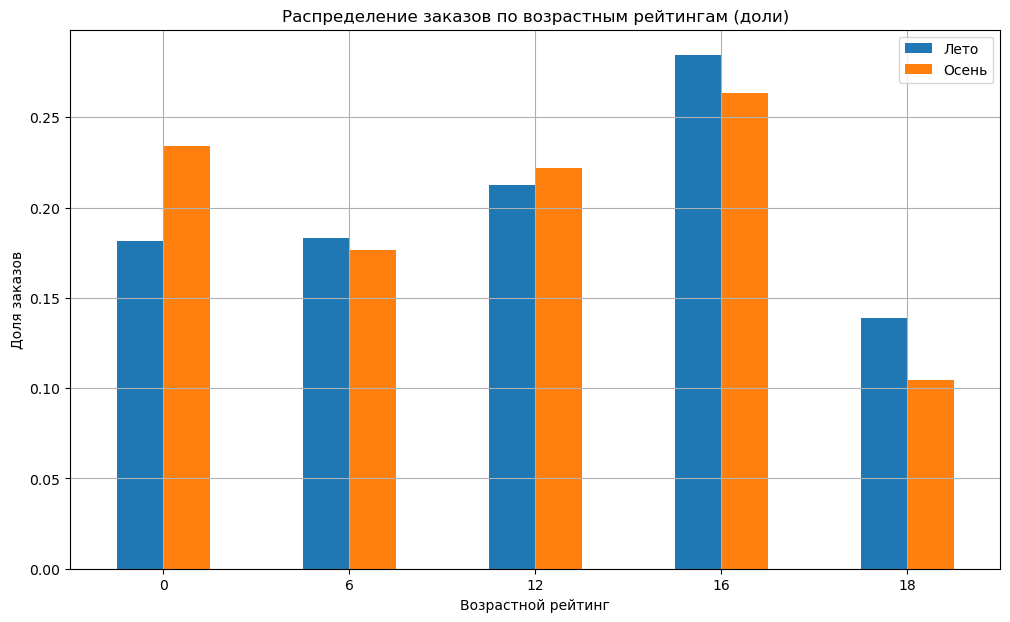

In [51]:
# Строим график отражающий распределение заказов по возрастным рейтингам для каждого месяца (в долях).
age_limits.plot(kind='bar', figsize=(12, 7), rot=0, grid=True)
plt.title('Распределение заказов по возрастным рейтингам (доли)')
plt.ylabel('Доля заказов')
plt.xlabel('Возрастной рейтинг')
plt.show()

- Осенью растет доля заказов на мероприятия с рейтингом `0` (лето: 18.1%, осень: 23.4%) и `12` (лето: 21.2%, осень: 22.2%), вероятно осенью появляется больше семейных, либо образовательных событий, чем может быть обусловлена популярность.
- `6`: в этой категории событий разница между летним и осенним периодами не так значительна (лето: 18.3%, осень: 17.7%), есть небольшой спад к осени, однако разница невелика.
- Мероприятия с рейтингом `16` остаются самыми популярными в обоих периодах (лето: 28.4%, осень: 26.3%), хотя осенью заметен небольшой спад, это все равно самый популярный сегмент.
- К осени популярность событий с рейтингом `18` снижается (лето: 13.9%, осень: 10.4%), это может быть связано с уменьшением подобного рода событий ввиду сезонности, либо смещение интереса в сторону других событий.
- Стоит упомянуть что возрастной рейтинг мероприятия не показывает реальный возраст людей, которые его посещают. Поэтому изменения долей по возрастным категориям скорее связаны с тем, какие события проходят в разное время года, а не с тем, что меняется возраст аудитории.

In [52]:
# Рассчитываем среднюю стоимость одного билета.
avg_price_summer = summer_orders.groupby('event_type_main')['one_ticket_revenue_rub'].mean()
avg_price_autumn = autumn_orders.groupby('event_type_main')['one_ticket_revenue_rub'].mean()

# Создаем и выводим датафрейм со средней стоимостью билета для каждого типа события по сезонам.
avg_price_by_devices_df = pd.DataFrame({'Лето': avg_price_summer,'Осень': avg_price_autumn})
avg_price_by_devices_df

,Лето,Осень
event_type_main,,
выставки,86.744476,91.905093
другое,87.998086,77.421380
концерты,309.558565,268.423003
спорт,55.247119,50.245481
стендап,218.518107,231.124973
театр,216.352713,176.076633
ёлки,271.436176,229.585589


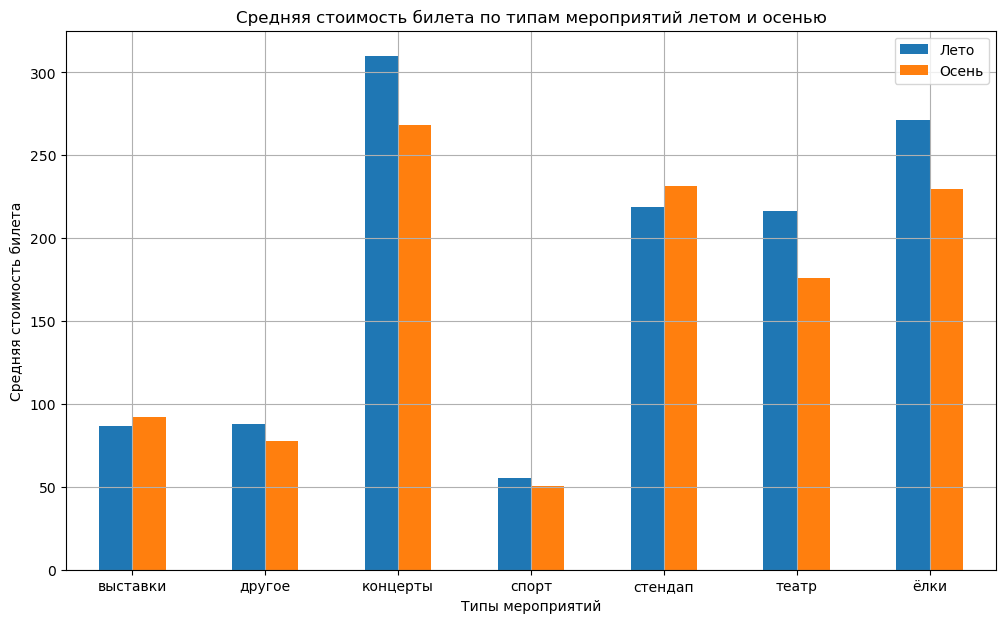

In [53]:
# Строим график отражающий среднюю стоимость билетыа в зависимости от мероприятия по сезонам.
avg_price_by_devices_df.plot(kind='bar', figsize=(12, 7), rot=0, grid=True)
plt.title('Средняя стоимость билета по типам мероприятий летом и осенью')
plt.ylabel('Средняя стоимость билета')
plt.xlabel('Типы мероприятий')
plt.show()

In [54]:
# Добавляем столбец с относительным изменением средней стоимости билета.
avg_price_by_devices_df['Изменение (%)'] = (
    (avg_price_by_devices_df['Осень'] - avg_price_by_devices_df['Лето']) / avg_price_by_devices_df['Лето']) * 100
avg_price_by_devices_df

,Лето,Осень,Изменение (%)
event_type_main,,,
выставки,86.744476,91.905093,5.949217
другое,87.998086,77.421380,-12.019246
концерты,309.558565,268.423003,-13.288459
спорт,55.247119,50.245481,-9.053210
стендап,218.518107,231.124973,5.769255
театр,216.352713,176.076633,-18.615935
ёлки,271.436176,229.585589,-15.418205


- Осенью билеты на `выставки` стали немного дороже (+5.9%), это может быть связано со сниженим популярности выставок в осеннее время. В летнее время есть возможность проводить выставки под открытым небом, которые, предположительно, имеют более низкую среднюю стоимость билета, в осеннее время фокус может смещаться на закрытые выставки.
- `Другое`: средняя стоимость билета падает к осени (-12%). Поскольку категория неоднородна, изменение средней цены, скорее всего, связано с появлением осенью более дешёвых мероприятий в этой группе.
- Средняя стоимость билетов на `концерты` осенью падает (-13.3%). Снижение может быть связано с увеличением доли массовых или недорогих концертов.
- Несмотря на большую популярность `спортивных событий` осенью, средняя стоимость билета снизилась (-9.1%), это также может быть связано с увеличением количества массовых мероприятий с невысокой стоимостью билета.
- Осенью выросла средняя стоимость билета на `стендапы` (+5.8%). Вероятно, новые шоу, либо большое количество премьер.
- Самое сильное снижение средней стоимости билета у `театров` (-18.6%). Осенью популярность театров значительно выше чем летом ввиду того, что осенью обычно выходит много премьер, можно предположить что ввиду этого может проводиться много мероприятий с низкой стоимостью билета, это может служить причиной снижения показателя.
- `Ёлки`: наблюдается заметное снижение средней стоимости билета (-15.4%), однако сложно выдвигать предположения относительно данной категории, поскольку данных о ней очень мало в датафрейме (0.7% записей на всю категорию, 273 записи (0.1%) - лето, 1691 (0.6%) - осень). Летний показатель недостаточно репрезентативен для сравнения, поэтому нет возможности сделать вывод об осеннем.

### Осенняя активность пользователей

In [55]:
# Создаем сводную таблицу, группирумем данные по дате, добавляем столбцы с количеством заказов, показателем DAU, 
# средней стоимостью билета, средним числом заказов на одного пользователя, номер и наименование дня недели.
autumn_orders = orders_and_events_df[orders_and_events_df['season'] == 'осень']

daily_dynamics = autumn_orders.groupby('created_dt_msk').agg(
    orders_count=('order_id', 'count'), 
    dau=('user_id', 'nunique'), 
    avg_ticket_price=('one_ticket_revenue_rub', 'mean')).reset_index()

# Рассчитываем среднее число заказов на одного пользователя.
daily_dynamics['avg_orders_per_user'] = daily_dynamics['orders_count'] / daily_dynamics['dau']

# Создаем словарь с с наименованиями дней недели.
weekday_map = {0: 'Понедельник', 1: 'Вторник', 2: 'Среда', 3: 'Четверг',
    4: 'Пятница', 5: 'Суббота', 6: 'Воскресенье'}

# Добавляем столбцы с днем недели.
daily_dynamics['weekday'] = daily_dynamics['created_dt_msk'].dt.weekday
daily_dynamics['weekday_name'] = daily_dynamics['created_dt_msk'].dt.weekday.map(weekday_map)

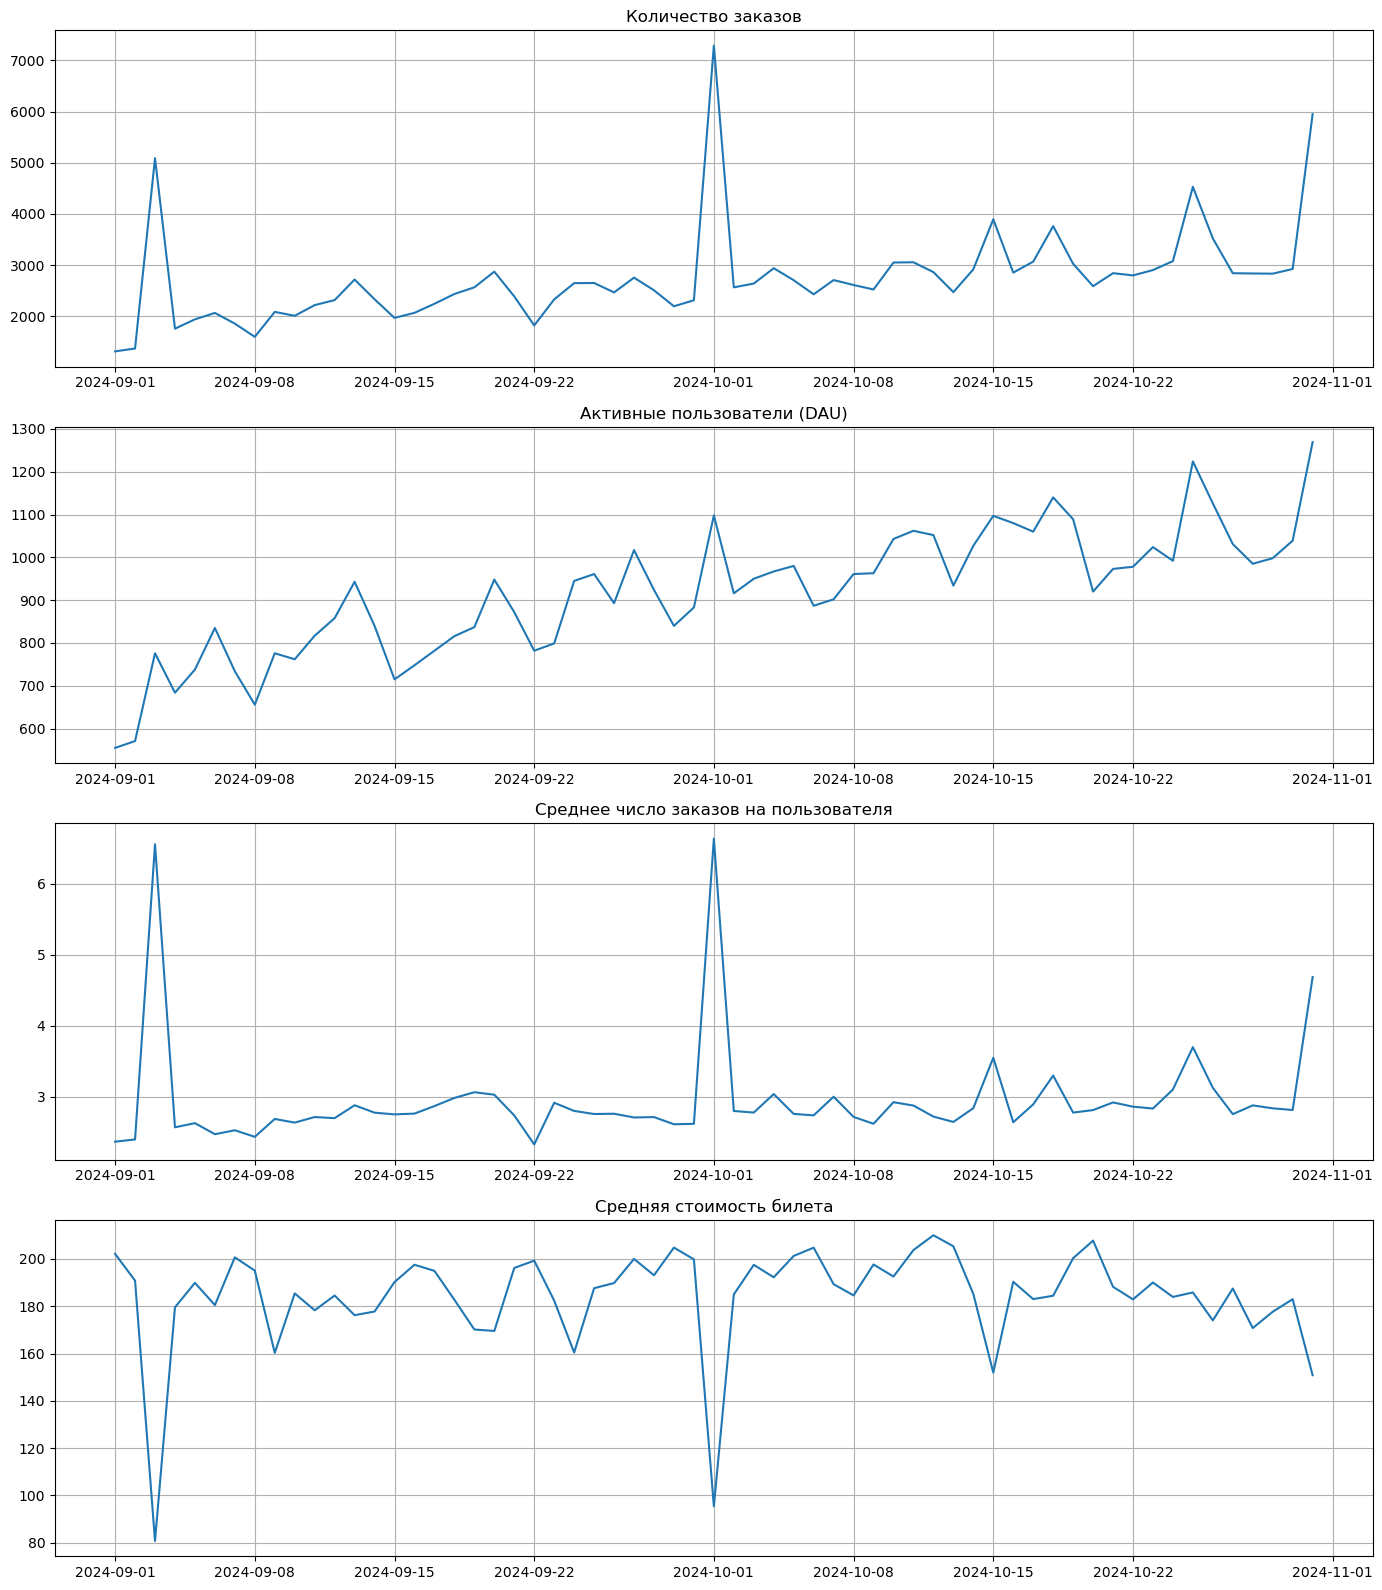

In [56]:
# Строим четыре линейных графика отражающие: количество заказов, DAU, среднее число заказов на пользователя 
# и среднюю стоимость билета по дням.
fig, axes = plt.subplots(4, 1, figsize=(14, 16))

# Создаем словарь с наименованиями столбцов и подписями.
metrics = [
    ('orders_count', 'Количество заказов'),
    ('dau', 'Активные пользователи (DAU)'),
    ('avg_orders_per_user', 'Среднее число заказов на пользователя'),
    ('avg_ticket_price', 'Средняя стоимость билета')
]

# Строим графики используя цикл.
for ax, (col, title) in zip(axes, metrics):
    ax.plot(daily_dynamics['created_dt_msk'], daily_dynamics[col])
    ax.set_title(title)
    ax.grid(True)

plt.tight_layout()
plt.show()

- С сентября по октябрь заметен планомерный рост количества заказов. На графике видны заметные скачки, например 03.09 - 5090 заказов, 01.10 - 7288 заказов, 25.10 - 4529 заказов, в такие дни средняя стоимость билета обычно значительно ниже чем в остальные, это можно объяснить наличием в датасете массовых мероприятий с относительно низкой стоимостью билета, которые занижают среднюю стоимость билета. Общая динамика показывает стабильный рост количества заказов.
- Показатель DAU также увеличивается с сентября по октябрь (555 -> 1269). Резких скачков на графике не наблюдается. 
- На графике со средним число заказов на пользователя присутствуют скачки, например: 03.09 - 6.56, 01.10 - 6.64, 31.10 - 4.69, в те же дни наблюдается увеличение количества заказов и пользовательской активности.
- На графике со средней стоимостью билета также присутствуют скачки (снижение средней стоимости). Прослеживается закономерность, в дни когда наблюдается резкое снижение средней стоимости, увеличивается общее количество заказов, среднее число заказов на пользователя, а также активность пользователей (DAU), хотя и не так явно. Это дополнительно подтверждает что в данных присутствут массовые мероприятия с невысокой стоимотью билета, которые вызывают подобные скачки. Без учета скачков, показатель средней стоимости относительно стабилен, хоть и немного уменьшается к началу ноября.

In [57]:
# Рассчитываем средние значения всех показателей.
weekday_summary = daily_dynamics.groupby(['weekday', 'weekday_name']).agg({
    'orders_count': 'mean',
    'dau': 'mean',
    'avg_orders_per_user': 'mean',
    'avg_ticket_price': 'mean'}).reset_index()

In [58]:
# Выводим сводную таблицу.
weekday_summary

,weekday,weekday_name,orders_count,dau,avg_orders_per_user,avg_ticket_price
0,0,Понедельник,2385.333333,851.555556,2.780879,184.935879
1,1,Вторник,3490.444444,933.000000,3.718898,157.113456
2,2,Среда,2536.555556,922.222222,2.748625,186.029908
3,3,Четверг,3007.777778,960.000000,3.060037,182.475129
4,4,Пятница,3086.625000,1017.000000,3.001000,186.575094
5,5,Суббота,2649.500000,952.125000,2.767739,194.179743
6,6,Воскресенье,2136.111111,813.333333,2.605601,199.662963


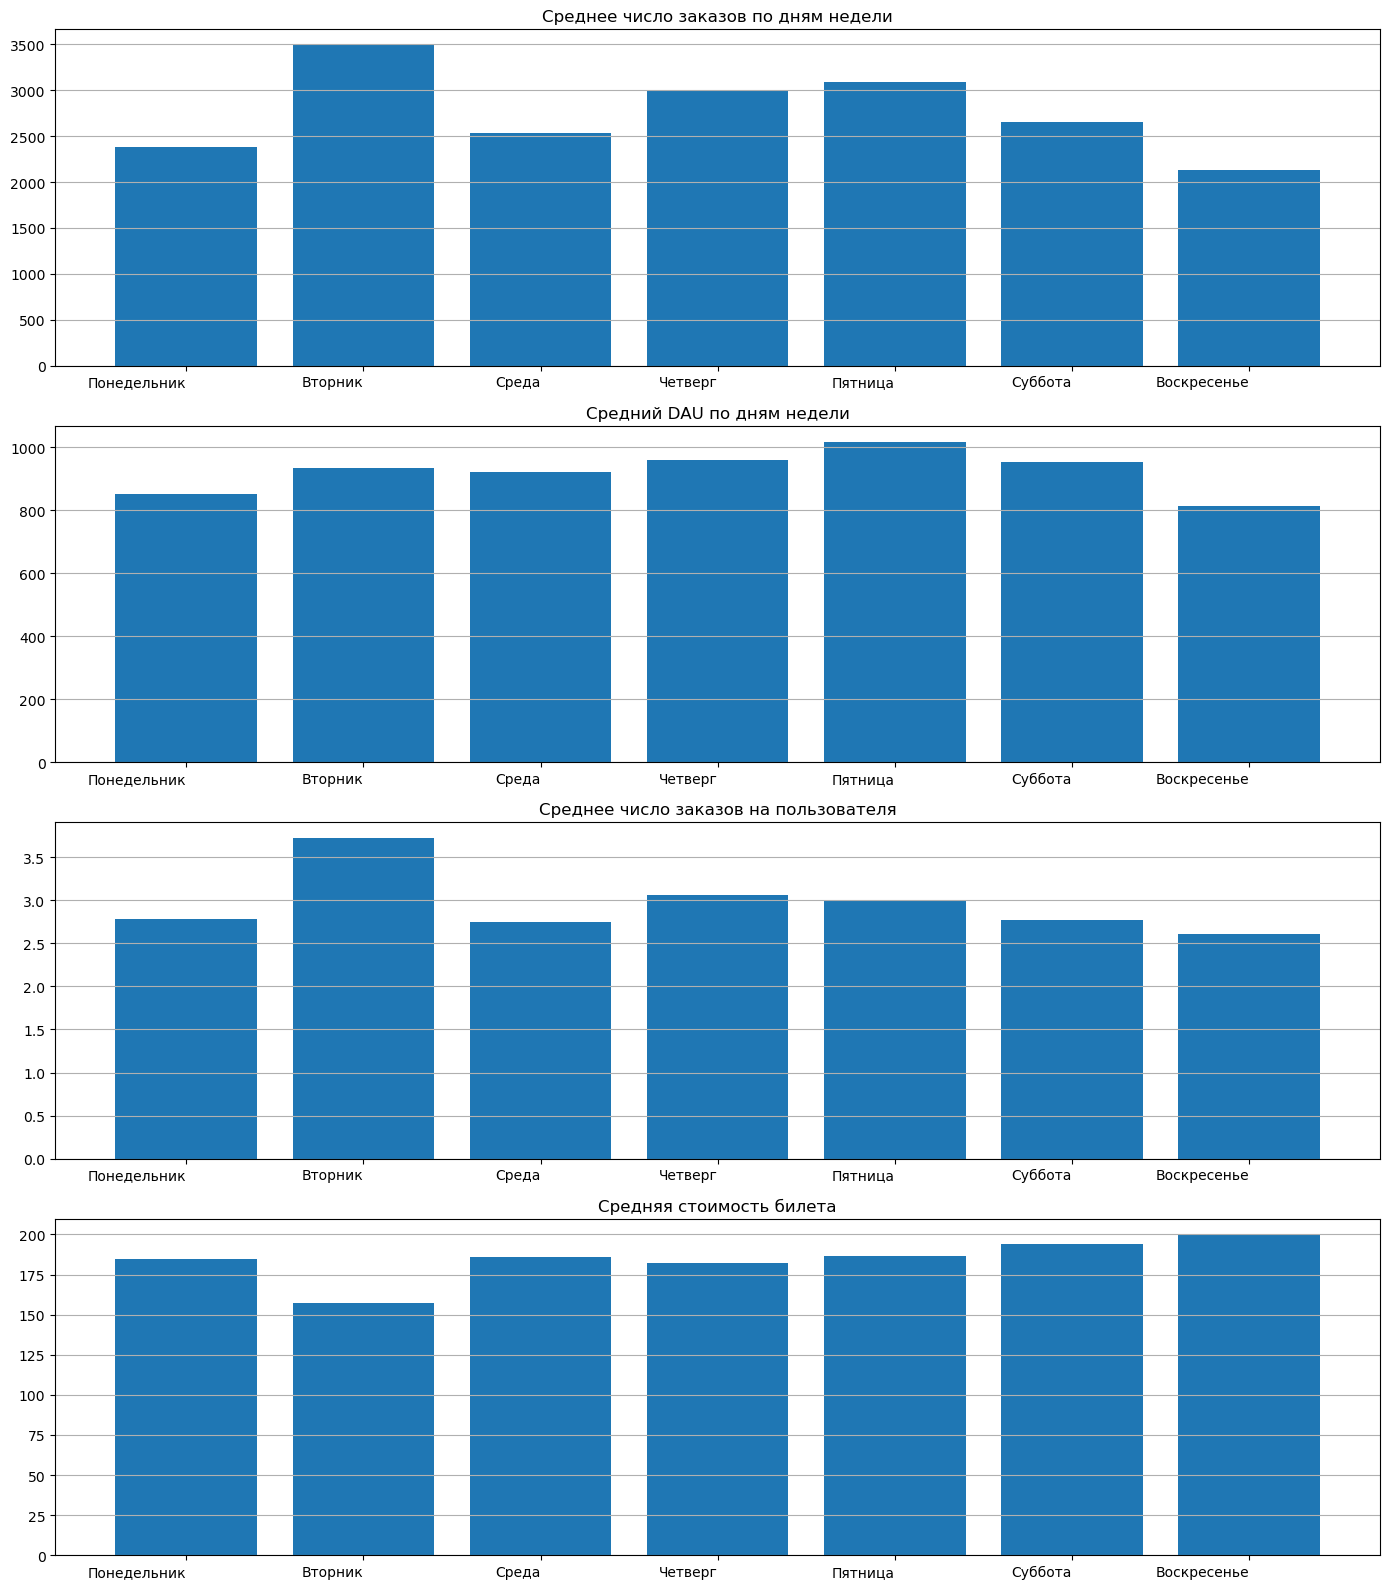

In [59]:
# Строим четыре столбчатых графика отражающих: количество заказов, DAU, среднее число заказов на пользователя 
# и среднюю стоимость билета по неделям.

# Сортируем дни недели по их номеру.
weekday_summary = weekday_summary.sort_values('weekday')

# Создаем графики.
fig, axes = plt.subplots(4, 1, figsize=(14, 16))

# Создаем словарь с наименованиями столбцов и подписями.
metrics = [
    ('orders_count', 'Среднее число заказов по дням недели'),
    ('dau', 'Средний DAU по дням недели'),
    ('avg_orders_per_user', 'Среднее число заказов на пользователя'),
    ('avg_ticket_price', 'Средняя стоимость билета')
]

# Создаем переменную с подписями дней недели.
labels = weekday_summary['weekday_name']

# Строим графики используя цикл.
for ax, (col, title) in zip(axes, metrics):
    ax.bar(weekday_summary['weekday'], weekday_summary[col])
    ax.set_title(title)
    ax.set_xticks(weekday_summary['weekday'])
    ax.set_xticklabels(labels, rotation=0, ha='right')
    ax.grid(True, axis='y')

plt.tight_layout()
plt.show()

In [60]:
# Разделяем дни на будние и выходные. Рассчитываем общие показатели для каждой категории. Выводим результат в виде таблицы.
def categorize_days(day):
    if day in ([5,6]):
        return 'Выходные'
    else:
        return 'Будние дни'

daily_dynamics['is_weekend'] = 0
daily_dynamics['is_weekend'] = daily_dynamics['weekday'].apply(categorize_days)
daily_dynamics.groupby('is_weekend')[['orders_count','dau','avg_orders_per_user','avg_ticket_price']].mean()

,orders_count,dau,avg_orders_per_user,avg_ticket_price
is_weekend,,,,
Будние дни,2897.136364,934.931818,3.063272,179.263412
Выходные,2377.705882,878.647059,2.681901,197.082624


In [61]:
weekday_summary

,weekday,weekday_name,orders_count,dau,avg_orders_per_user,avg_ticket_price
0,0,Понедельник,2385.333333,851.555556,2.780879,184.935879
1,1,Вторник,3490.444444,933.000000,3.718898,157.113456
2,2,Среда,2536.555556,922.222222,2.748625,186.029908
3,3,Четверг,3007.777778,960.000000,3.060037,182.475129
4,4,Пятница,3086.625000,1017.000000,3.001000,186.575094
5,5,Суббота,2649.500000,952.125000,2.767739,194.179743
6,6,Воскресенье,2136.111111,813.333333,2.605601,199.662963


- Пиковое количество заказов наблюдается по вторникам (в среднем 3490.44 заказов), меньше всего заказов приходится на воскресенье - 2136.11 заказов в среднем.
- Наивысшие показатели DAU зафиксированы по пятницам (1017), четвергам (960) и субботам (952.13), самый низкий - в воскресенье (813.33). К концу недели пользовательская активность повышается, и снижается на выходных.
- Во вторник зафиксировано наивысшее количество заказов на пользователя (3.72), в остальные дни показатель заметно ниже, самый низкий - в воскресенье (2.61).
- Самая высокая средняя стоимость билета зафиксирована на выходных: воскресенье - 199.66, суббота - 194.18, во вторник средняя стоимость билета самая низкая - 157.11. Средняя стоимость растёт к выходным, достигая максимума в воскресенье, что может отражать разность типов мероприятий (в выходные дороже и менее массовые, в будние более массовые, но стоимость билета ниже).

- Показатели также были рассчитаны отдельно для будних и выходных дней, и полученные значения полностью подтверждают выявленные ранее закономерности. Среднее количество заказов в будние дни составляет 2897.14, в выходные этот показатель ниже - 2377.71. Показатель DAU выше в будние дни: 934.93 против 878.65 (выходные). Среднее количество заказов в будние дни выше - 3.06, в выходные - 2.68. Средняя стоимость билета выше по выходным: 197.08 против 179.26 (будние).
- Будние дни обеспечивают больший объём заказов за счёт массовых событий и более высокой активности пользователей. Выходные дают меньше заказов, но более высокий средний чек.

### Популярные события и партнёры

In [62]:
# Группируем данные по регионам и считаем количество уникальных событий и количество заказов.
region_events = orders_and_events_df.groupby('region_name').agg(
                                events_count=('event_id', 'nunique'), 
                                orders_count=('order_id', 'count')).sort_values(by='events_count', ascending=False)


# Добавляем столбцы с долями событий и заказов.
region_events['events_share'] = region_events['events_count'] / orders_and_events_df['event_id'].nunique()
region_events['orders_share'] = region_events['orders_count'] / orders_and_events_df['order_id'].count()

# Переупорядочиваем столбцы.
region_events = region_events[['events_count', 'events_share', 'orders_count', 'orders_share']]

# Сбрасываем индекс.
region_events = region_events.reset_index()

# Переименовываем столбцы.
region_events = region_events.rename(columns={'region_name': 'Регион',  
                                              'events_count': 'Количество мероприятий', 
                                              'events_share': 'Доля мероприятий', 
                                              'orders_count': 'Количество заказов', 
                                              'orders_share': 'Доля заказов'})

# Выводим ТОП-10 регионов отсортированных по количеству мероприятий.
region_events.head(10)

,Регион,Количество мероприятий,Доля мероприятий,Количество заказов,Доля заказов
0,Каменевский регион,5792,0.263177,85398,0.302989
1,Североярская область,3777,0.171619,43591,0.154659
2,Широковская область,1217,0.055298,16087,0.057076
3,Светополянский округ,1059,0.048119,7464,0.026482
4,Речиновская область,701,0.031852,6266,0.022232
5,Травяная область,667,0.030307,4719,0.016743
6,Горицветская область,551,0.025036,5153,0.018283
7,Серебринская область,541,0.024582,5586,0.019819
8,Яблоневская область,534,0.024264,6120,0.021714
9,Тепляковская область,528,0.023991,4384,0.015554


- Среди регионов есть явные лидеры по количеству мероприятий, и количеству заказов, это: Каменевский регион	(5792 - мероприятий, 85398 - заказов), Североярская область (3777 - мероприятий, 43591 - заказов).
- На них приходится 43.5% всех мероприятий (26.3% - Каменевский регион, 17.2% - Североярская область) и 45.8% всех заказов (30.3% - Каменевский регион, 15.4% - Североярская область), что говорит о высокой концентрации рынка, почти половина активности сосредоточена всего в двух регионах.
- Следующими по значимости идут Широковская область, Светополянский округ, Речиновская область, данные регионы хоть и сильно отстают от лидирующих, входят в ТОП-5 по количеству мероприятий, их доля от общего количества мероприятий варьируется от 3.2% до 5.5%, и от 2.2% до 5.7% варьируется доля от общего количества заказов.
- Распределение региональной активности неравномерное, присутствует выраженные лидеры (Каменевский регион, Североярская область), а также значительный длинный хвост из регионов с низкими долями.

In [63]:
# Группируем данные по билетным партнерам и считаем количество уникальных событий и количество заказов.
service_events = orders_and_events_df.groupby('service_name').agg(
                                events_count=('event_id', 'nunique'), 
                                orders_count=('order_id', 'count'), 
                                total_revenue=('revenue_rub','sum')).sort_values(by='events_count', ascending=False)

# Округляем до двух знаков после запятой чтобы сумма отображалась в десятичном виде.
service_events['total_revenue'] = service_events['total_revenue'].round(2)

# Добавляем столбцы с долями событий и заказов.
service_events['events_share'] = service_events['events_count'] / orders_and_events_df['event_id'].nunique()
service_events['orders_share'] = service_events['orders_count'] / orders_and_events_df['order_id'].count()

# Переупорядочиваем столбцы.
service_events = service_events[['events_count', 'events_share', 'orders_count', 'orders_share', 'total_revenue']]

# Сбрасываем индекс.
service_events = service_events.reset_index()

# Переименовываем столбцы.
service_events = service_events.rename(columns={'service_name': 'Билетный оператор',  
                                                'events_count': 'Количество мероприятий', 
                                                'events_share': 'Доля мероприятий', 
                                                'orders_count': 'Количество заказов', 
                                                'orders_share': 'Доля заказов', 
                                                'total_revenue': 'Общая выручка'})

# Выводим ТОП-10 билетных операторов отсортированных по количеству мероприятий.
service_events.head(10)

,Билетный оператор,Количество мероприятий,Доля мероприятий,Количество заказов,Доля заказов,Общая выручка
0,Лови билет!,4813,0.218693,40505,0.143710,16675516.72
1,Билеты без проблем,4019,0.182615,57862,0.205292,24322601.57
2,Билеты в руки,3486,0.158397,39803,0.141220,13194799.29
3,Облачко,2335,0.106098,26402,0.093673,18588613.86
4,Лучшие билеты,1741,0.079108,17619,0.062512,2724084.19
5,Мой билет,1297,0.058933,34434,0.122171,22042364.72
6,Тебе билет!,1061,0.048210,5189,0.018410,2962308.82
7,Прачечная,1026,0.046619,10222,0.036267,4746810.52
8,Весь в билетах,855,0.038850,16425,0.058275,16533231.19
9,Яблоко,714,0.032443,5004,0.017754,3868336.88


- Среди билетных операторов можно выделить ТОП-5 по количеству мероприятий: Лови билет! (4813), Билеты без проблем (4019), Билеты в руки (3486), Облачко (2335), Лучшие билеты (1741); вместе, они составляют 74.5% всех мероприятий.
- Также можно выделить ТОП-5 по количеству заказов: Билеты без проблем (57862), Лови билет! (40505), Билеты в руки (39803), Мой билет (34434), Облачко (26402); их суммарная доля от общего количества заказов составляет 70.6%.
- Лидерами по выручке являются: Билеты без проблем (24.3 млн), Мой билет (22 млн), Облачко (18.6 млн), Лови билет! (16.7 млн), Весь в билетах (16.5 млн). При этом Мой билет и Весь в билетах	имеют значительно меньше мероприятий чем другие лидирующие операторы, но обеспечивают очень высокую выручку, вероятно, они продают билеты на более дорогие или более популярные мероприятия.
- Распределение неравномерное, среди билетных операторов есть явные лидеры которые формируют большую часть мероприятий, заказов и выручки.

## Статистический анализ данных

- ***Формулируем гипотезы для проверки различий в количестве заказов между пользователями мобильных и стационарных устройств.***
- H₀: Среднее количество заказов на одного пользователя мобильного приложения не имеет статистической разницы со средним количеством заказов стационарных устройств.
- H₁: Среднее количество заказов на одного пользователя мобильного приложения выше по сравнению с пользователями стационарных устройств.

In [64]:
# Создаем два датафрейма для двух типов устройств, отбираем данные только за осенний период.
mobile_subset = orders_and_events_df[(orders_and_events_df['device_type_canonical'] == 'mobile') & (orders_and_events_df['season'] == 'осень')]
desktop_subset = orders_and_events_df[(orders_and_events_df['device_type_canonical'] == 'desktop') & (orders_and_events_df['season'] == 'осень')]

In [65]:
# Проверяем датафреймы на пересекающиеся user_id и выводим на экран их количество, количество уникальных user_id в каждом датафрейме
# и размеры датафреймов в исходном варианте и после удаления пересекающиеся user_id.
intersection = set(mobile_subset['user_id']) & set(desktop_subset['user_id'])
print(f"Пересекающихся user_id: {len(intersection)}\n")

print(f"Уникальное количество user_id в mobile_subset: {mobile_subset['user_id'].nunique()}")
print(f"Уникальное количество user_id в desktop_subset: {desktop_subset['user_id'].nunique()}\n")

print(f"Размер датафрейма mobile_subset: {mobile_subset.shape[0]}")
print(f"Размер датафрейма desktop_subset: {desktop_subset.shape[0]}\n")

print(f"Уникальное количество user_id в mobile_subset после удаления пересекающихся user_id: {mobile_subset[~mobile_subset['user_id'].isin(intersection)]['user_id'].nunique()}")
print(f"Уникальное количество user_id в desktop_subset после удаления пересекающихся user_id: {desktop_subset[~desktop_subset['user_id'].isin(intersection)]['user_id'].nunique()}\n")

print(f"Размер датафрейма mobile_subset при удалении пересекающихся user_id: {mobile_subset[~mobile_subset['user_id'].isin(intersection)].shape[0]}")
print(f"Размер датафрейма desktop_subset при удалении пересекающихся user_id: {desktop_subset[~desktop_subset['user_id'].isin(intersection)].shape[0]}")

Пересекающихся user_id: 3235

Уникальное количество user_id в mobile_subset: 14110
Уникальное количество user_id в desktop_subset: 4862

Размер датафрейма mobile_subset: 133656
Размер датафрейма desktop_subset: 34239

Уникальное количество user_id в mobile_subset после удаления пересекающихся user_id: 10875
Уникальное количество user_id в desktop_subset после удаления пересекающихся user_id: 1627

Размер датафрейма mobile_subset при удалении пересекающихся user_id: 31181
Размер датафрейма desktop_subset при удалении пересекающихся user_id: 3207


- В обоих датафреймах присутствуют пересекающиеся `user_id`, и поскольку единицей наблюдения является пользователь, нельзя считать выборки независимыми в исходном виде, нарушается предпосылка о независимости наблюдений.
- При удалении записей с пересекающимися `user_id` теряется заметная часть данных (mobile_subset: 133656 > 31181, desktop_subset: 34239 > 3207), однако выборки по-прежнему содержат достаточно наблюдений для проведения статистического анализа и проверки гипотез.
- В связи с этим для последующего анализа из датафреймов `mobile_subset` и `desktop_subset` будут удалены записи с пересекающимися `user_id`.

In [66]:
# Удаляем записи с пересекающимися user_id из датафреймов.
mobile_subset = mobile_subset[~mobile_subset['user_id'].isin(intersection)]
desktop_subset = desktop_subset[~desktop_subset['user_id'].isin(intersection)]

In [67]:
# Считаем количество заказов для каждого пользователя. 
mobile_orders = mobile_subset.groupby('user_id')['order_id'].count()
desktop_orders = desktop_subset.groupby('user_id')['order_id'].count()

In [68]:
# Выводим сводную статистику mobile_orders.
mobile_orders.describe()

count    10875.000000
mean         2.867218
std          4.149300
min          1.000000
25%          1.000000
50%          2.000000
75%          3.000000
max        123.000000
Name: order_id, dtype: float64

In [69]:
# Выводим сводную статистику desktop_orders.
desktop_orders.describe()

count    1627.000000
mean        1.971112
std         3.051590
min         1.000000
25%         1.000000
50%         1.000000
75%         2.000000
max        56.000000
Name: order_id, dtype: float64

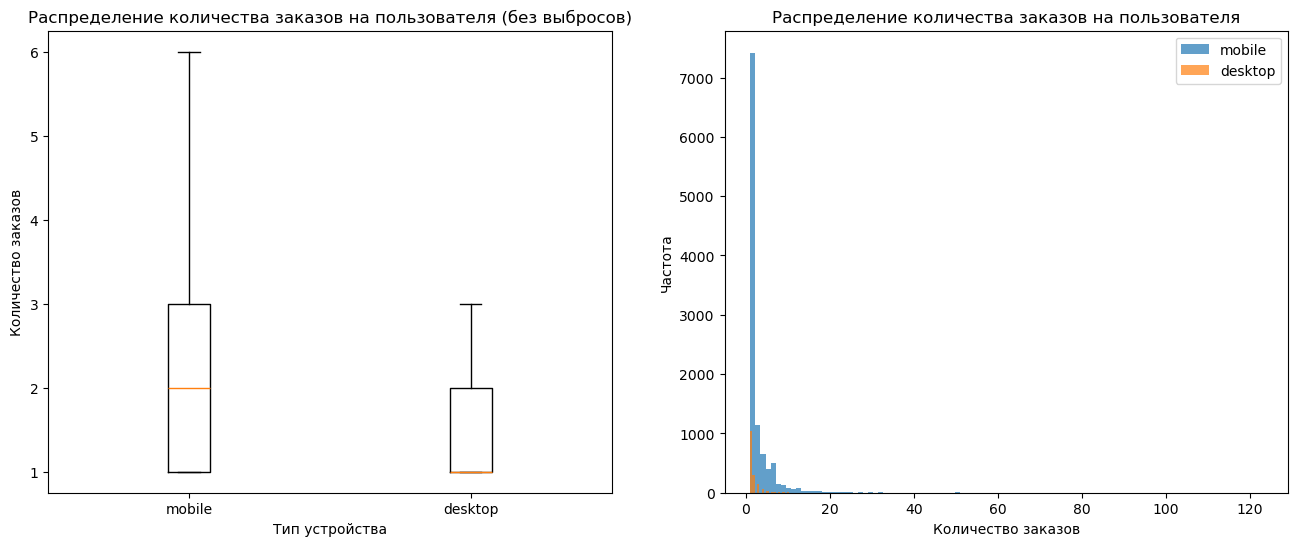

In [70]:
# Строим диаграмму размаха и гистограмму для отражения распределения количества заказов. 
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.boxplot([mobile_orders, desktop_orders], tick_labels=['mobile','desktop'], showfliers=False)
plt.xlabel('Тип устройства')
plt.ylabel('Количество заказов')
plt.title('Распределение количества заказов на пользователя (без выбросов)')

plt.subplot(1,2,2)
plt.hist(mobile_orders, bins=100, alpha=0.7, label='mobile')
plt.hist(desktop_orders, bins=100, alpha=0.7, label='desktop')
plt.xlabel('Количество заказов')
plt.ylabel('Частота')
plt.title('Распределение количества заказов на пользователя')
plt.legend()
plt.show()

- Распределение количества заказов на пользователя имеет правостороннюю ассиметрию и содержит выбросы.
- При этом объём выборок является достаточным для применения параметрических тестов, так как в силу центральной предельной теоремы распределение средних значений можно считать близким к нормальному.
- В качестве основного метода сравнения средних значений используется t-тест как более мощный статистический критерий.
- Дополнительно для проверки устойчивости результатов применяется непараметрический тест Манна-Уитни.

- ***Проводим t-тест Уэлча.***

In [71]:
# Устанавливаем степень значимости.
alpha = 0.05

# Проводим тест.
test_result = ttest_ind(mobile_orders, desktop_orders, equal_var=False, alternative='greater')

if test_result.pvalue > alpha:
    print(f'pvalue={test_result.pvalue} > {alpha}')
    print('Недостаточно оснований для отвержения нулевой гипотезы. Не найдены статистически значимые различия между группами.')
else:
    print(f'pvalue={test_result.pvalue} < {alpha}')
    print('Нулевая гипотеза не находит подтверждения. Обнаружены статистически значимые различия между группами.')
    
# Выводим p-value в десятичном виде.
print(f"p-value: {test_result.pvalue:.20f}")

pvalue=1.6138950218844191e-25 < 0.05
Нулевая гипотеза не находит подтверждения. Обнаружены статистически значимые различия между группами.
p-value: 0.00000000000000000000


- ***Дополнительно проводим непараметрический тест Манна-Уитни.***

In [72]:
# Устанавливаем степень значимости.
alpha = 0.05

# Проводим тест.
mw_test = mannwhitneyu(mobile_orders, desktop_orders, alternative='greater')

if mw_test.pvalue > alpha:
    print(f'pvalue={mw_test.pvalue} > {alpha}')
    print('Недостаточно оснований для отвержения нулевой гипотезы. Не найдены статистически значимые различия между группами.')
else:
    print(f'pvalue={mw_test.pvalue} < {alpha}')
    print('Нулевая гипотеза не находит подтверждения. Обнаружены статистически значимые различия между группами.')

# Выводим p-value в десятичном виде.
print(f"p-value: {mw_test.pvalue:.20f}")

pvalue=1.883056523841333e-39 < 0.05
Нулевая гипотеза не находит подтверждения. Обнаружены статистически значимые различия между группами.
p-value: 0.00000000000000000000


- В качестве основного метода сравнения средних значений был использован t-тест Уэлча, так как объём выборок является достаточным, а тест не требует равенства дисперсий и устойчив к отклонениям от нормальности распределений.
- Результаты t-теста Уэлча показали статистически значимые различия между группами пользователей мобильных и стационарных устройств (p-value < 0.05), что позволяет отклонить нулевую гипотезу.
- Поскольку тест является правосторонним, можно сделать вывод, что среднее количество заказов на одного пользователя статистически значимо выше у пользователей мобильных устройств по сравнению с пользователями стационарных устройств.
- Для дополнительной проверки устойчивости результатов был проведён непараметрический тест Манна-Уитни, который также выявил статистически значимые различия между выборками (p-value < 0.05).
- Полученные результаты согласуются между собой и подтверждают вывод о том, что пользователи мобильных устройств в среднем совершают больше заказов, чем пользователи стационарных устройств.

- ***Формулируем гипотезы для проверки различий во времени между заказами между пользователями мобильных и стационарных устройств.***
- H₀: Среднее время между заказами пользователей мобильных приложений и пользователями стационарных устройств не имеет статистической разницы.
- H₁: Среднее время между заказами пользователей мобильных приложений выше по сравнению с пользователями стационарных устройств.

In [73]:
# Считаем среднее время между заказами для каждого пользователя.
mobile_time_gap = mobile_subset.groupby('user_id')['days_since_prev'].mean()
desktop_time_gap = desktop_subset.groupby('user_id')['days_since_prev'].mean()

In [74]:
# Удаляем NA значения (пользователей которые совершили только один заказ).
mobile_time_gap = mobile_time_gap.dropna()
desktop_time_gap = desktop_time_gap.dropna()

In [75]:
# Приводим значения с типом Float64 к float64, чтобы графики и тест рбаотали корректно.
mobile_time_gap = mobile_time_gap.astype('float64')
desktop_time_gap = desktop_time_gap.astype('float64')

In [76]:
# Выводим сводную статистику mobile_time_gap.
mobile_time_gap.describe()

count    7029.000000
mean       25.175566
std        30.155236
min         0.000000
25%         2.833333
50%        14.000000
75%        36.000000
max       148.000000
Name: days_since_prev, dtype: float64

In [77]:
# Выводим сводную статистику desktop_time_gap.
desktop_time_gap.describe()

count    903.000000
mean      31.159228
std       36.441449
min        0.000000
25%        0.000000
50%       16.000000
75%       52.750000
max      146.000000
Name: days_since_prev, dtype: float64

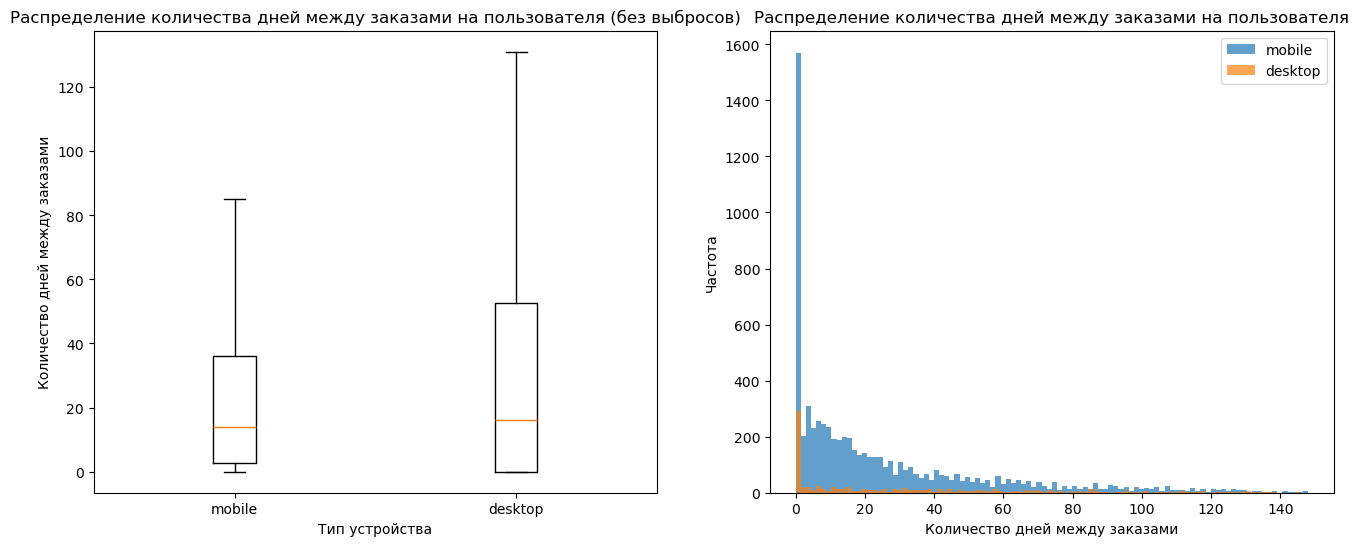

In [78]:
# Строим диаграмму размаха и гистограмму для отражения распределения количества дней между заказами. 
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.boxplot([mobile_time_gap, desktop_time_gap], tick_labels=['mobile','desktop'], showfliers=False)
plt.xlabel('Тип устройства')
plt.ylabel('Количество дней между заказами')
plt.title('Распределение количества дней между заказами на пользователя (без выбросов)')

plt.subplot(1,2,2)
plt.hist(mobile_time_gap, bins=100, alpha=0.7, label='mobile')
plt.hist(desktop_time_gap, bins=100, alpha=0.7, label='desktop')
plt.xlabel('Количество дней между заказами')
plt.ylabel('Частота')
plt.title('Распределение количества дней между заказами на пользователя')
plt.legend()
plt.show()

- Распределение времени между заказами имеет выраженную правостороннюю асимметрию.
- При этом объём выборок является достаточным для применения параметрических статистических тестов, так как в силу центральной предельной теоремы распределение средних значений можно считать близким к нормальному.
- В качестве основного метода сравнения средних значений будет использован t-тест Уэлча.
- Для дополнительной проверки устойчивости результатов также будет применён непараметрический тест Манна-Уитни.

- ***Проводим t-тест Уэлча.***

In [79]:
# Устанавливаем степень значимости.
alpha = 0.05

# Проводим тест.
test_result_2 = ttest_ind(mobile_time_gap, desktop_time_gap, equal_var=False, alternative='greater')

if test_result_2.pvalue > alpha:
    print(f'pvalue={test_result_2.pvalue} > {alpha}')
    print('Недостаточно оснований для отвержения нулевой гипотезы. Не найдены статистически значимые различия между группами.')
else:
    print(f'pvalue={test_result_2.pvalue} < {alpha}')
    print('Нулевая гипотеза не находит подтверждения. Обнаружены статистически значимые различия между группами.')
    
# Выводим p-value в десятичном виде.
print(f"p-value: {test_result_2.pvalue:.20f}")

pvalue=0.9999987298365219 > 0.05
Недостаточно оснований для отвержения нулевой гипотезы. Не найдены статистически значимые различия между группами.
p-value: 0.99999872983652193792


- ***Дополнительно проводим непараметрический тест Манна-Уитни.***

In [80]:
# Устанавиваем уровень значимости.
alpha = 0.05

# Проводим тест.
mw_test_2 = mannwhitneyu(mobile_time_gap, desktop_time_gap, alternative='greater')

if mw_test_2.pvalue > alpha:
    print(f'pvalue={mw_test_2.pvalue} > {alpha}')
    print('Недостаточно оснований для отвержения нулевой гипотезы. Не найдены статистически значимые различия между группами.')
else:
    print(f'pvalue={mw_test_2.pvalue} < {alpha}')
    print('Нулевая гипотеза не находит подтверждения. Обнаружены статистически значимые различия между группами.')

# Выводим p-value в десятичном виде.
print(f"p-value: {mw_test_2.pvalue:.20f}")

pvalue=0.7877721698318554 > 0.05
Недостаточно оснований для отвержения нулевой гипотезы. Не найдены статистически значимые различия между группами.
p-value: 0.78777216983185538446


- В качестве основного метода сравнения среднего времени между заказами был использован t-тест Уэлча, так как объём выборок является достаточным, а тест не требует равенства дисперсий и устойчив к отклонениям от нормальности распределений.
- Результаты t-теста Уэлча не выявили статистически значимых различий между пользователями мобильных и стационарных устройств по среднему времени между заказами (p-value > 0.05), в связи с чем нулевая гипотеза не была отвергнута.
- Из этого можно сделать вывод что на основании полученных данных нельзя утверждать, что пользователи мобильных устройств совершают повторные заказы через более длительный период времени по сравнению с пользователями стационарных устройств.
- Для дополнительной проверки устойчивости результатов был проведён непараметрический тест Манна-Уитни, который также не выявил статистически значимых различий между распределениями временных интервалов между заказами (p-value > 0.05).
- Результаты обоих статистических тестов согласуются между собой и указывают на отсутствие статистически значимых различий во времени между заказами у пользователей мобильных и стационарных устройств.

---
- В ходе анализа были проверены две гипотезы, связанные с активностью пользователей мобильных и стационарных устройств за осенний период.
- **Количество заказов на одного пользователя**
    - В качестве основного метода сравнения был использован t-тест Уэлча, который выявил статистически значимые различия между пользователями мобильных и стационарных устройств (p-value < 0.05). Поскольку тест был правосторонним, можно сделать вывод, что среднее количество заказов на одного пользователя статистически значимо выше у пользователей мобильных устройств.
    - Для дополнительной проверки устойчивости результата был проведён непараметрический тест Манна-Уитни, который также показал статистически значимые различия между группами. Полученные результаты согласуются между собой и подтверждают вывод о более высокой активности мобильных пользователей в контексте количества заказов.
- **Время между заказами пользователей**
    - В качестве основного метода сравнения среднего времени между заказами был использован t-тест Уэлча. Результаты теста не выявили статистически значимых различий между пользователями мобильных и стационарных устройств по среднему времени между заказами (p-value > 0.05), в связи с чем нулевая гипотеза не была отвергнута.
    - Для проверки устойчивости результатов был дополнительно проведён непараметрический тест Манна-Уитни, который также не выявил статистически значимых различий между распределениями временных интервалов между заказами. Результаты обоих тестов согласуются между собой.

## Общий вывод и рекомендации

- В анализе были использованы данные сервиса бронирования билетов Яндекс Афиша, включающие информацию о заказах, мероприятиях, пользователях и пр. Данные были представлены в виде трех датасетов: final_tickets_orders_df.csv (информация о заказах), final_tickets_events_df (информация о событиях) и final_tickets_tenge_df.csv (информация о валюте). Датасеты охватывают осенний период (с 1 июня по 30 октября 2024 года).
- Перед анализом данные были объединены в единый датафрейм, очищены от дублирующих записей и выбросов, и дополнены полями необходимыми для дальнейшего анализа (выручка в единой валюте, выручка с продажи одного билета на мероприятие, месяц, сезон).

***Основные выводы:***

- Популярные категории мероприятий
    - Концерты остаются самым востребованным типом мероприятий и летом, и осенью, хотя их доля снижается (43% -> 37%). Осенью аудитория смещается в сторону более сезонных форматов: растёт популярность театральных представлений (21% -> 25%) и спортивных событий (2% -> 11%). Также увеличивается доля мероприятий категории ёлки в предновогодний период. С другой стороны, выставки, стендап и разноплановые события из категории другое теряют долю по сравнению с летом.
- Динамика среднего чека по категориям
    - Осенью средняя стоимость билета изменилась по-разному в разных категориях мероприятий. Небольшой рост среднего чека наблюдается у выставок и стендапа. В остальных категориях - концертах, театре, спорте и ёлках, средняя стоимость билета снизилась. Наиболее заметное снижение произошло в театральных мероприятиях и концертах. Для категории ёлки корректные выводы ограничены малым объёмом летних данных.
- Пользовательская активность и динамика спроса
    - Анализ пользовательской активности показывает устойчивый рост числа заказов и DAU в период с сентября по октябрь. На отдельных датах наблюдаются краткосрочные всплески активности, которые совпадают с появлением массовых мероприятий с низкой стоимостью билета, в такие дни увеличиваются общее количество заказов и среднее число заказов на пользователя, а средний чек снижается. В целом динамика заказов и активности пользователей остаётся положительной, а средняя стоимость билета - относительно стабильной.
- Активность по дням недели
    - Будние дни обеспечивают больше заказов и более высокую пользовательскую активность, пик приходится на вторник. К выходным активность снижается, но растёт средняя стоимость билета, достигая максимума в воскресенье. Разделение на будни и выходные полностью подтверждает эти различия: будни дают больший объём заказов, а выходные - более высокий средний чек.
- Активность по регионам
    - Региональная активность распределена неравномерно: два региона: Каменевский и Североярская область - являются явными лидерами, на них приходится почти половина всех мероприятий и заказов. Остальные регионы обладают значительно меньшими долями, формируя длинный хвост низкой активности. Это указывает на высокую концентрацию рынка в отдельных территориях.
- Партнёрская структура
    - Среди партнёров также наблюдается выраженная концентрация: несколько крупных операторов обеспечивают основную часть мероприятий, заказов и выручки. ТОП-5 лидеров формирует около 70-75% активности. При этом отдельные операторы с меньшим числом мероприятий демонстрируют высокую выручку, что может быть связано с продажей билетов на более дорогие или популярные события.

***Результаты проверки гипотез:***

- Количество заказов на одного пользователя
    - Проверка различий между пользователями мобильных и стационарных устройств показала, что мобильные пользователи в среднем совершают больше заказов. Основной t-тест Уэлча выявил статистически значимые различия между группами, что позволило отклонить нулевую гипотезу. Дополнительный непараметрический тест Манна-Уитни также подтвердил наличие статистически значимых различий. Можно сделать вывод что мобильные пользователи проявляют более высокую активность в контексте количества заказов на одного пользователя.
- Время между заказами пользователей
    - Проверка различий во времени между заказами не выявила статистически значимых различий между пользователями мобильных и стационарных устройств. Основной t-тест Уэлча показал, что различия в среднем времени между заказами не являются статистически значимыми, в связи с чем нулевая гипотеза не была отвергнута. Непараметрический тест Манна-Уитни дал такой же результат. На основании проведённого анализа нельзя утверждать, что пользователи мобильных устройств совершают повторные заказы реже или с более длительными интервалами по сравнению с пользователями стационарных устройств.

- На основании проведённого анализа можно сделать вывод, что пользователи мобильных устройств в среднем совершают больше заказов на одного пользователя, однако статистически значимых различий во времени между заказами у мобильных и стационарных пользователей обнаружено не было. Это означает, что более высокая активность мобильных пользователей проявляется в общем количестве заказов, но не сопровождается отличиями в регулярности совершения покупок.

***Рекомендации:***

- Работа с регионами
    - В данных присутствуют явные лидеры среди регионов, это Каменевский регион и Североярская область, они представляют 43.5% всех мероприятий и 45.8% всех заказов. Рекомендуется укреплять партнёрства с ведущими площадками и организаторами в этих регионах.
    - Имеет смысл развивать регионы из топ-5, поскольку они таже имеют потенциал для роста.
    - Фокус на регионах с низкой активностью: поскольку большую часть мероприятий и заказов берут на себя лидирущие регионы, имеет смысл в развитии тех, которые отстают по активности. В таких регионах можно запустить стимулирующие акции, специальные программы для партнеров и т.д.

- Работа с партнерами
    - Топ-5 билетных партнеров формируют 74.5% всех мероприятий, рекомендуется сфокусироваться на работе с ними: экслюзивные условия, совместные маркетинговые акции и т.д.
    - Развивать партнеров с высоким средним чеком, например: Мой билет и Весь в билетах, хотя у них меньше мероприятий, они приносят высокую выручку.

- Сезонность
    - Усилить предложение осенних театральных и спортивных событий. Осенью эти категории растут особенно сильно (театр +4.6 п.п., спорт +8.8 п.п.). Сервис может заранее подготавливать рекомендации и рекламные кампании под осенний спрос.

- Недельный спрос
    - По будним дням зафиксирована более высокая пользовательская активность, тогда как по выходным средний чек заметно выше. Это позволяет рекомендовать усиление предложения массовых и доступных мероприятий в будние дни, а в выходные - акцент на более дорогие и премиальные события.

- Развитие активности мобильных пользователей
    - Мобильные пользователи в среднем совершают больше заказов на одного пользователя, что указывает на более высокую вовлечённость. Рекомендуется продолжать развитие мобильного канала и стимулировать оформление заказов (персональные рекомендации, промо-акции), с целью дальнейшего роста общего количества заказов.
- Поддержка активности пользователей стационарных устройств
    - Пользователи стационарных устройств совершают меньше заказов на одного пользователя, при этом статистически значимых различий во времени между заказами по сравнению с мобильными пользователями не выявлено. Это позволяет рассматривать данный сегмент как стабильный, но менее активный по объёму заказов. Рекомендуется фокусироваться на стимулировании роста количества заказов, например за счёт персонализированных рекомендаций, акций и улучшения пользовательского опыта на десктопе.